In [6]:
import os, sys
sys.path.append('../../')
import neurons

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'viridis'

spec_norm = Normalize(0, 1)
spec_mapp = ScalarMappable(cmap=cmap, norm=spec_norm)

spike_norm = Normalize(-100, 50)
spike_mapp = ScalarMappable(cmap=cmap, norm=spike_norm)

# Load Data

In [7]:
x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

x_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

In [8]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [9]:
def show_image(image):
    fig, ax = plt.subplots(figsize=(4,4), dpi=80)
    im = ax.imshow(image)
    ax.axis('off')
#     fig.colorbar(im, ax=ax)
    plt.show()

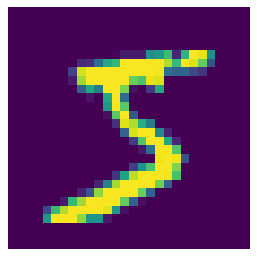

In [10]:
show_image(x_train[0])

### restructure data for training

In [11]:
masks = {}
for i in range(10):
    masks[i] = y_train == i
    
masks_test = {}
for i in range(10):
    masks_test[i] = y_test == i

In [12]:
data = {}
for i in range(10):
    data[i] = x_train[masks[i]]
    
data_t = {}
for i in range(10):
    data_t[i] = x_test[masks_test[i]]

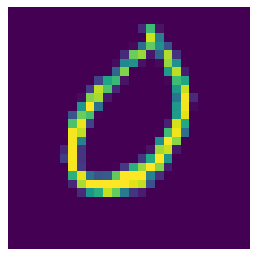

In [13]:
show_image(data[0][2230])

# Define Network Architecture

In [17]:
net = neurons.Network()
ntype = neurons.LIFrate

params = {
    'v_rest': -70,
    'v_thres': -55,
    'R': 10,
    'gamma': 0.1,
    'theta': 0.5,
    'tau_s': 10
}

In [18]:
net.add(neurons.Sensory, 784, 'input')
net.add(ntype, 1000, 'hidden', **params)
net.add(ntype, 10, 'output', **params)

In [19]:
net.connect('input', 'hidden')
net.connect('hidden', 'output')

In [20]:
net.compile()

network successfully compiled.



# Define some functions for plotting

In [21]:
def plot_synapses(synapses):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Synaptic Weights')
    ax.set_xlabel('Pre-Synaptic Neuron')
    ax.set_ylabel('Post-Synaptic Neuron')
    im = ax.pcolormesh(np.arange(synapses.shape[1]), np.arange(synapses.shape[0]), synapses, shading='nearest', cmap=cmap)#, norm=Normalize(-1,1))
    fig.colorbar(im, ax=ax)
    plt.show()

In [22]:
def plot_voltage(voltage_history, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Membrane Potential')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(voltage_history.shape[0]) * dt, np.arange(voltage_history.shape[1]), voltage_history.T, shading='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax, label='Voltage [mV]')
    plt.show()

In [23]:
def plot_outputs(output_history, **kwargs):
    fig, ax = plt.subplots(figsize=(16,6), dpi=80)
    ax.set_title('Spikes')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron #')
    ax.set(**kwargs)
    im = ax.pcolormesh(np.arange(output_history.shape[0]) * dt, np.arange(output_history.shape[1]), output_history.T, shading='nearest', cmap='gray_r', norm=Normalize(0,1))
    ax.grid(alpha=0.2)
    fig.colorbar(im, ax=ax, label='Firing Rate [1/max_rate]')
    plt.show()

In [24]:
def plot_history_choice(history, choice=0, title=None, **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,10), dpi=80, sharex=True, constrained_layout=True)
    fig.suptitle(title)
    
    ax1.set_title('current')
    ax1.plot(np.arange(history.current.shape[0]) * dt, history.current.T[choice], lw=1)
    ax1.set_ylabel('current [mA]')
    ax1.set(**kwargs)
    ax1.grid(alpha=0.2)
    
    ax2.set_title('membrane potential')
    ax2.plot(np.arange(history.voltage.shape[0]) * dt, history.voltage.T[choice], '-', lw=1)
    ax2.set_ylabel('voltage [mV]')
#     ax2.set_ylim(-120, 0)
    ax2.set(**kwargs)
    ax2.grid(alpha=0.2)
    
    ax3.set_title('spikes')
    ax3.plot(np.arange(history.outputs.shape[0]) * dt, history.outputs.T[choice], '-', lw=1)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('firing rate')
    ax3.set_ylim(0,1)
    ax3.set(**kwargs)
    ax3.grid(alpha=0.2)
    
    plt.show()

# Training Simulation

In [25]:
Os = np.load('synapses_fc_hidden1000_output.npy')

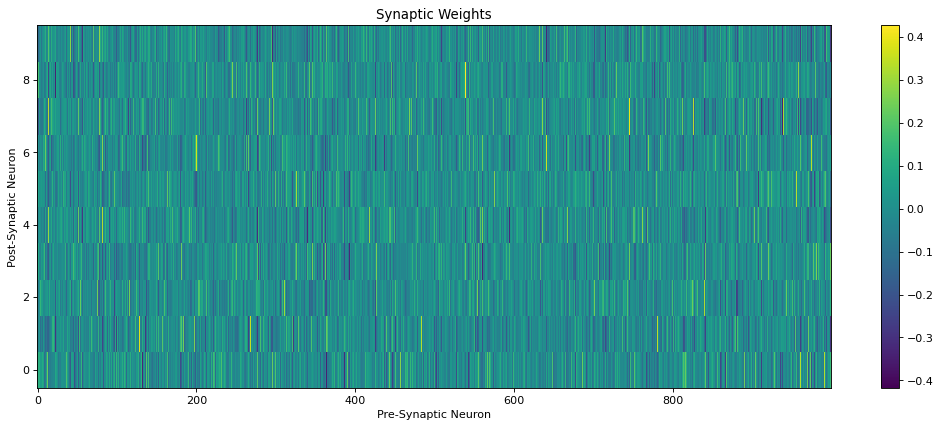

In [26]:
net.bundles['hidden'].synapses = np.load('synapses_fc_hidden1000_hidden.npy')
net.bundles['output'].synapses = np.load('synapses_fc_hidden1000_output.npy')

# plot_synapses(net.bundles['hidden'].synapses)
plot_synapses(net.bundles['output'].synapses)

In [45]:
net.reset_history()
net.record_history = True
net.bundles['output'].train = True

dt = 0.001
n_digits_per_class = 10
time_per_digit = 1
start = 1200

steps_per_digit = int(time_per_digit / dt)
steps = n_digits_per_class*10*steps_per_digit
time = time_per_digit * n_digits_per_class * 10

print(f"total time: {time} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"total_steps: {steps}")
print(f"steps per digit: {steps_per_digit}")
print()

print("begin simulation...")
for i in range(start, start + n_digits_per_class):
    for j in range(10):
        net.bundles['input'].outputs[:] = data[j][i].reshape(-1)
        net.bundles['output'].stim = (np.array([l == j for l in range(10)])*2 - 1) * 3
        for k in range(steps_per_digit):
            net.step(dt)
            print(f'{((i - start)*10*steps_per_digit + j*steps_per_digit + k+1)/steps*100:.2f}%', end='\r')

net.bundles['output'].stim = None
print('simulation ended.')

total time: 100 seconds
time_per_digit: 1 seconds

dt: 0.001
total_steps: 100000
steps per digit: 1000

begin simulation...
simulation ended.


## Network Analysis after Training Simulation

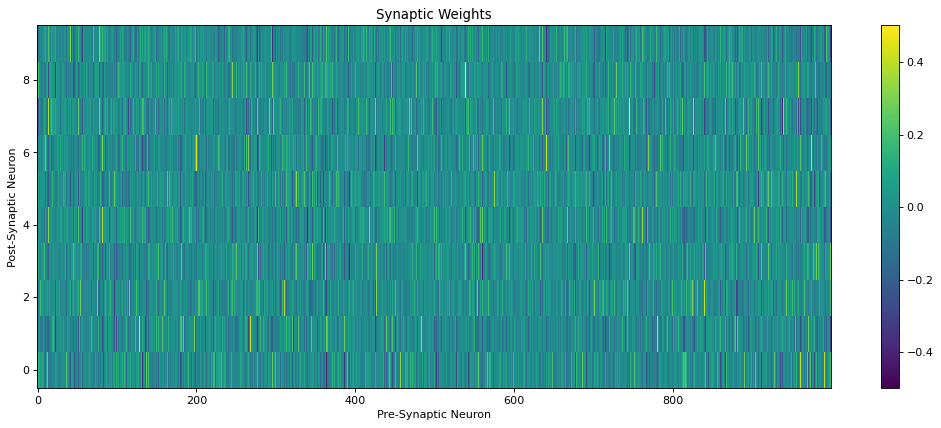

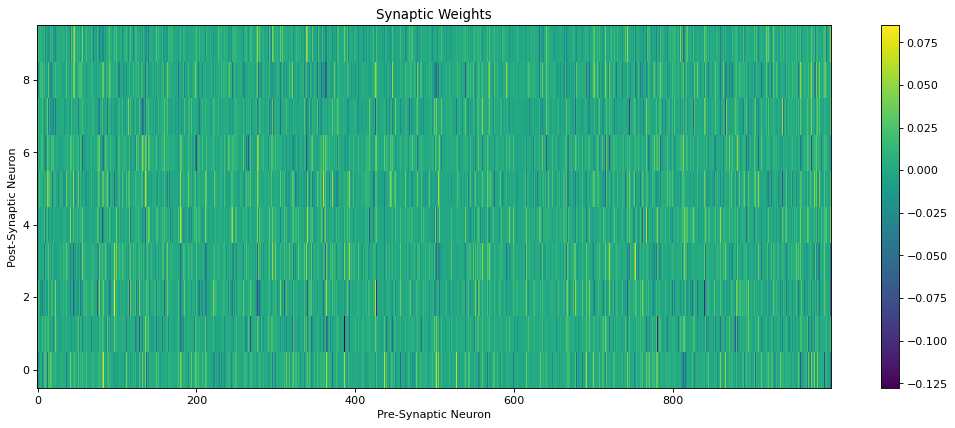

In [46]:
# plot_synapses(net.bundles['hidden'].synapses)
plot_synapses(net.bundles['output'].synapses)
plot_synapses(Os - net.bundles['output'].synapses)

In [47]:
# plot_voltage(net.history['hidden'].voltage)
# plot_outputs(net.history['hidden'].outputs)

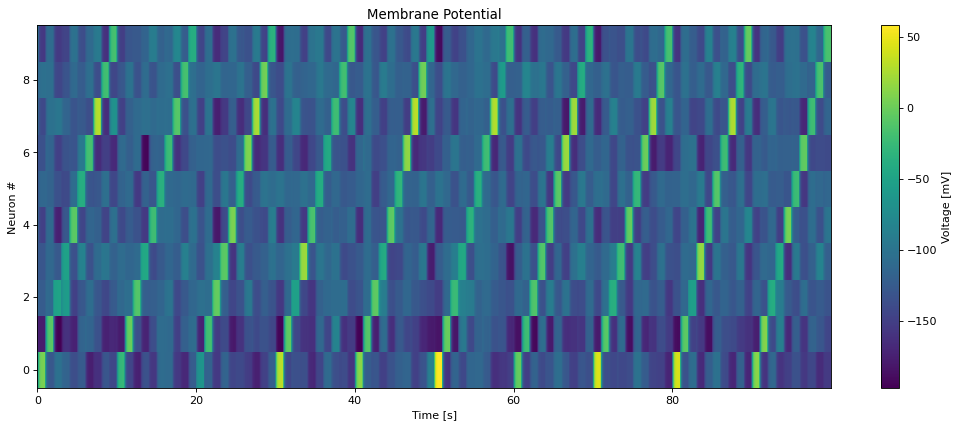

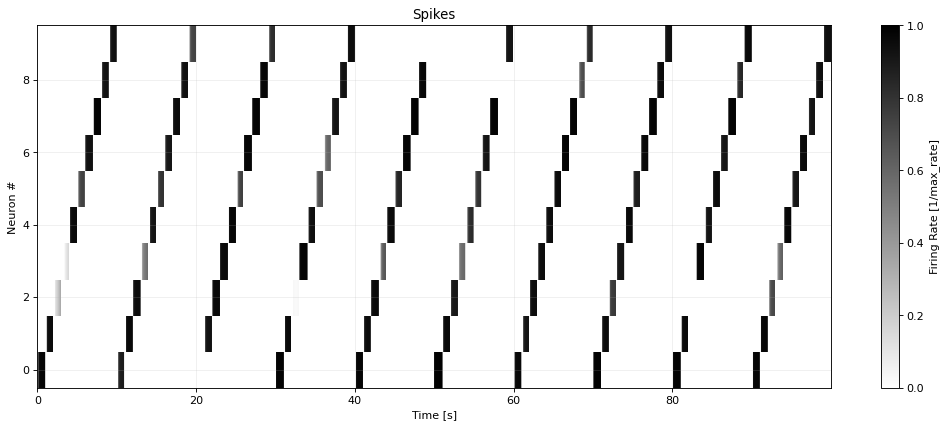

In [48]:
plot_voltage(net.history['output'].voltage)
plot_outputs(net.history['output'].outputs)

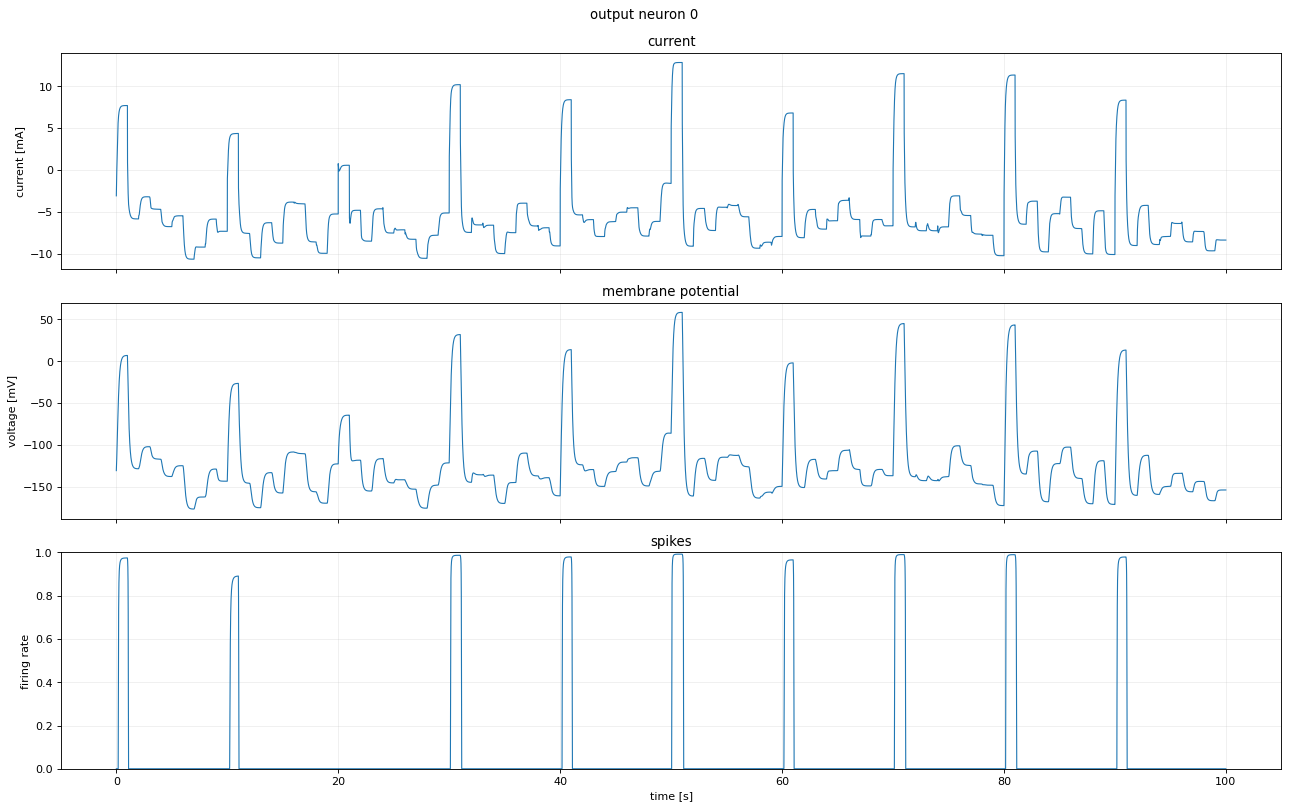

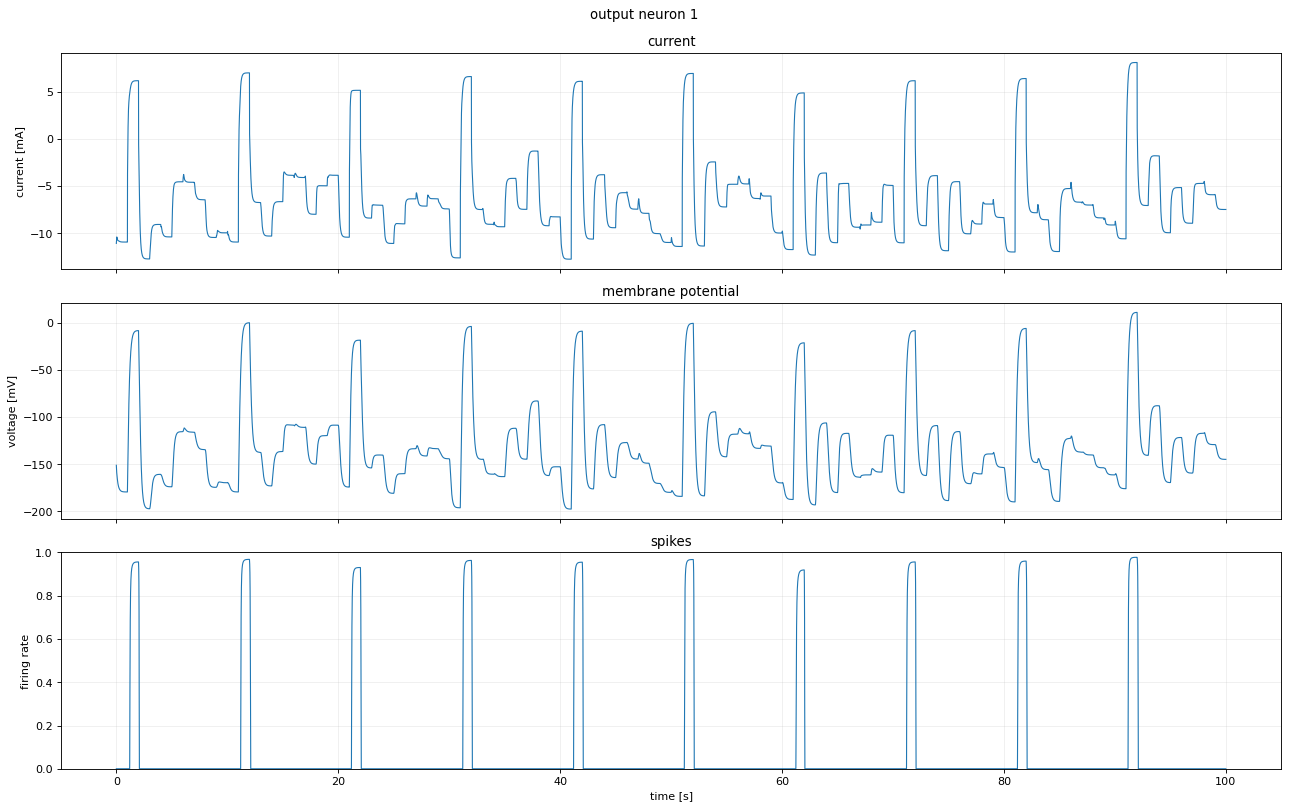

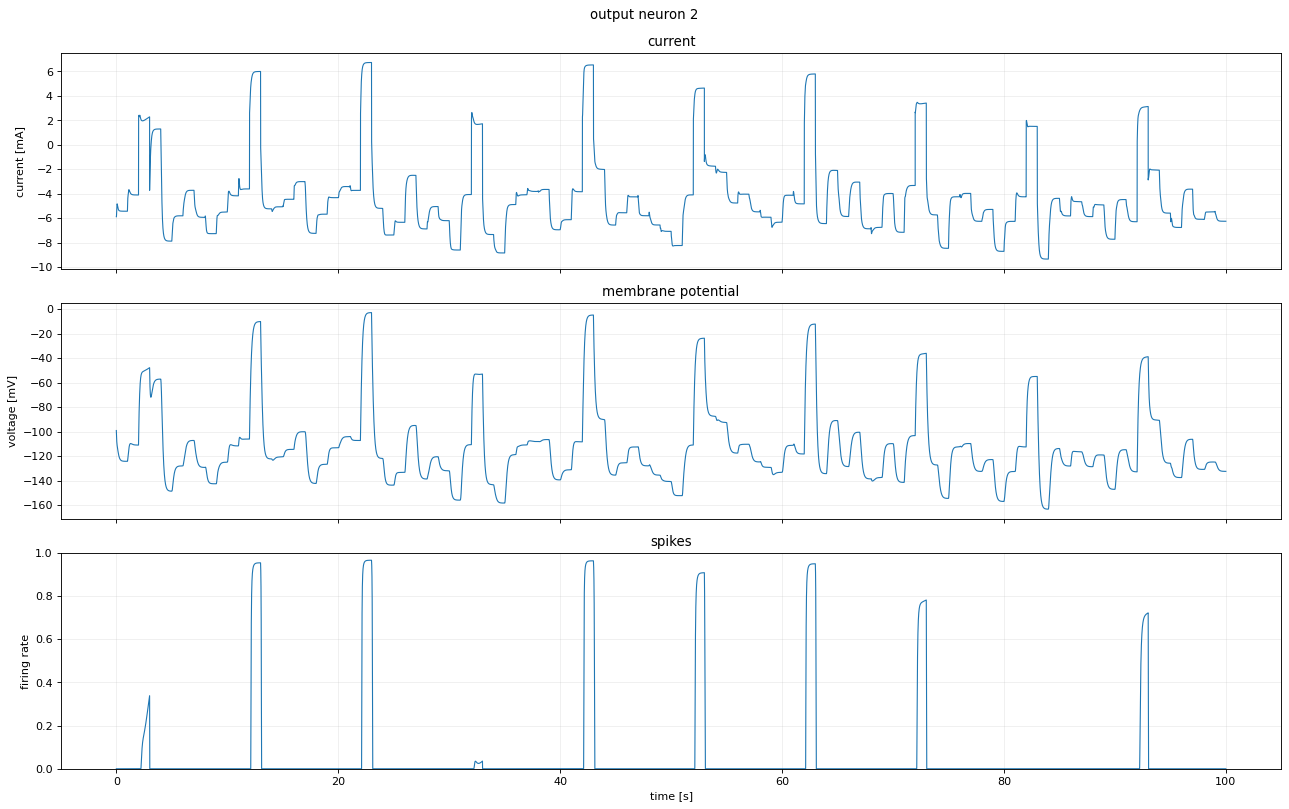

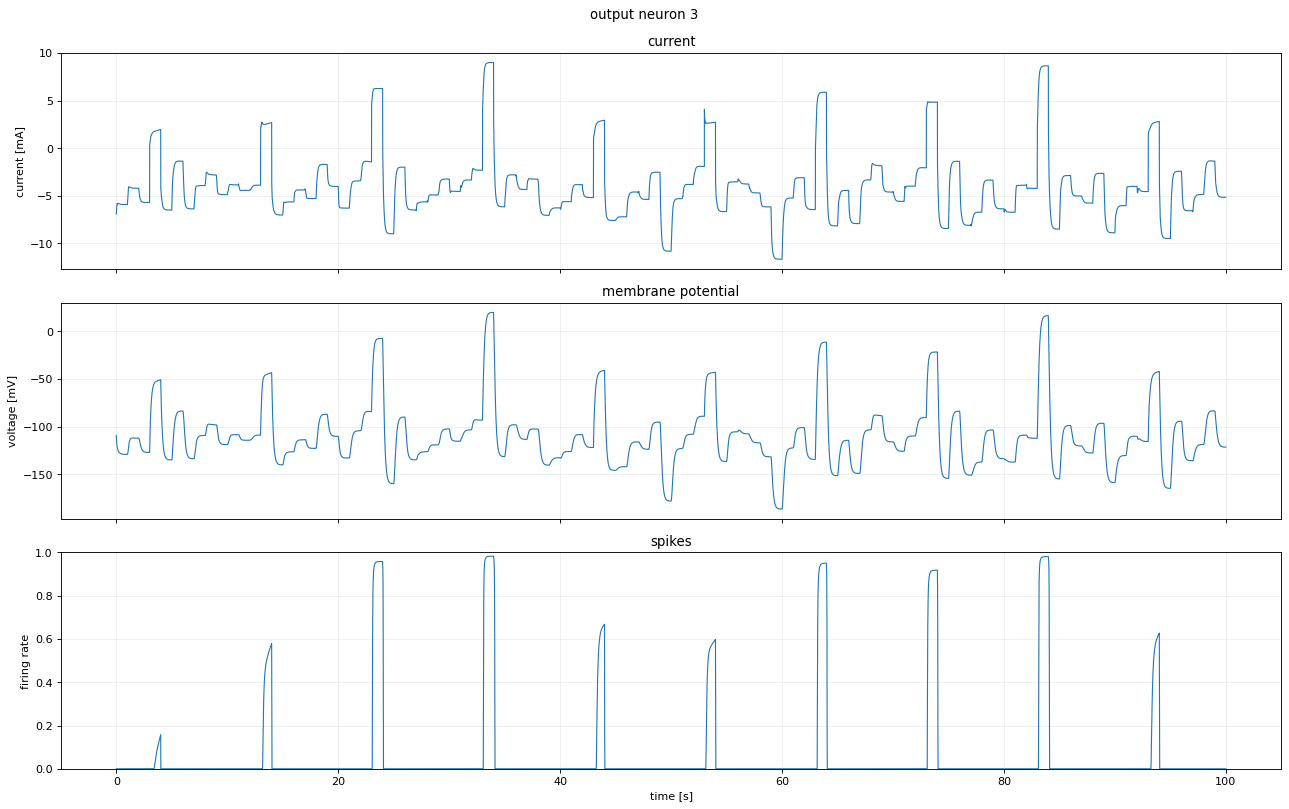

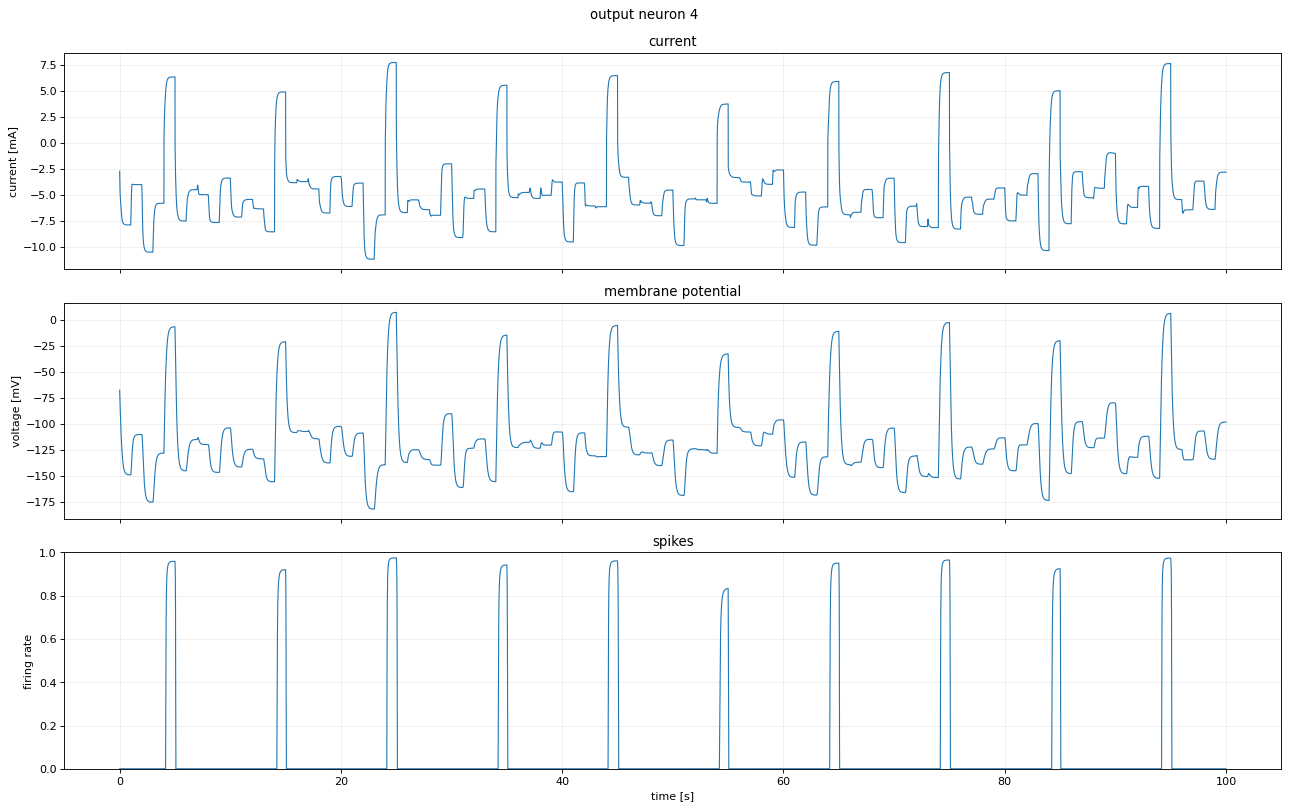

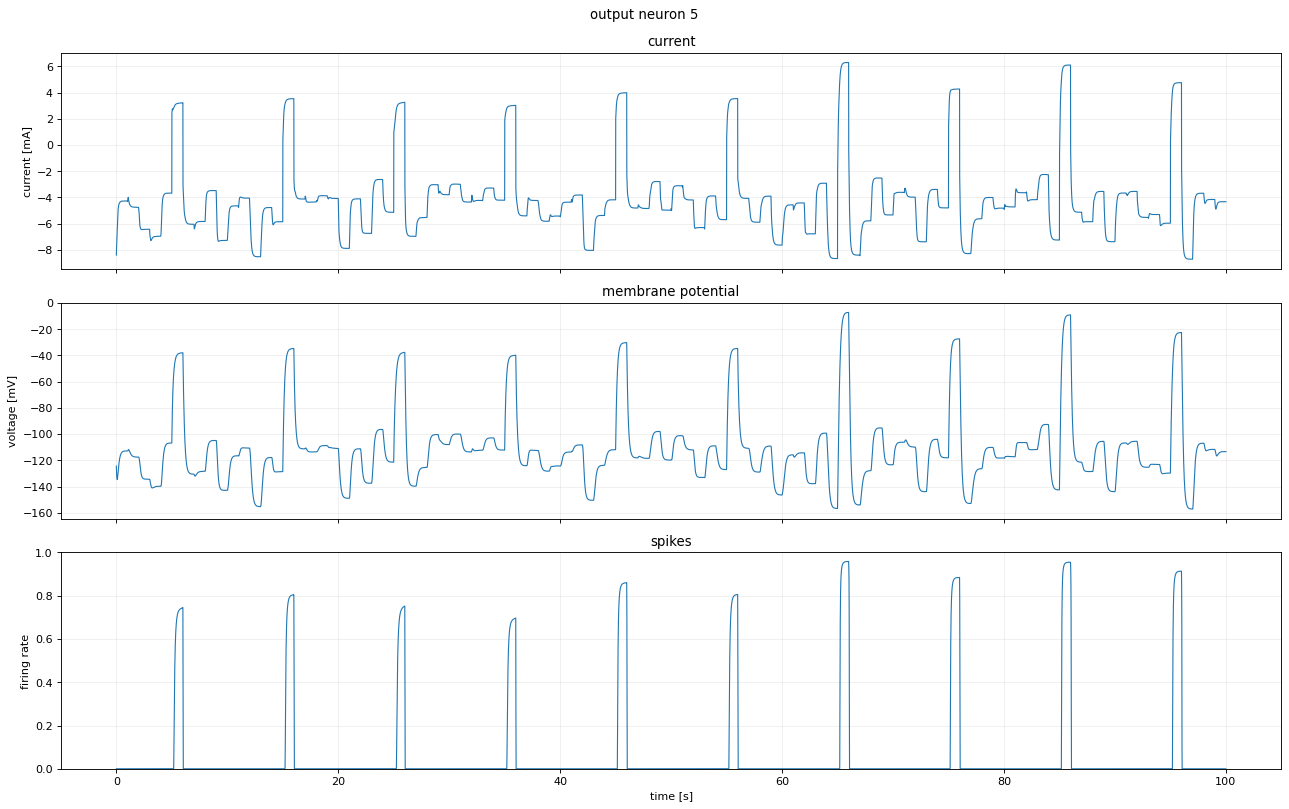

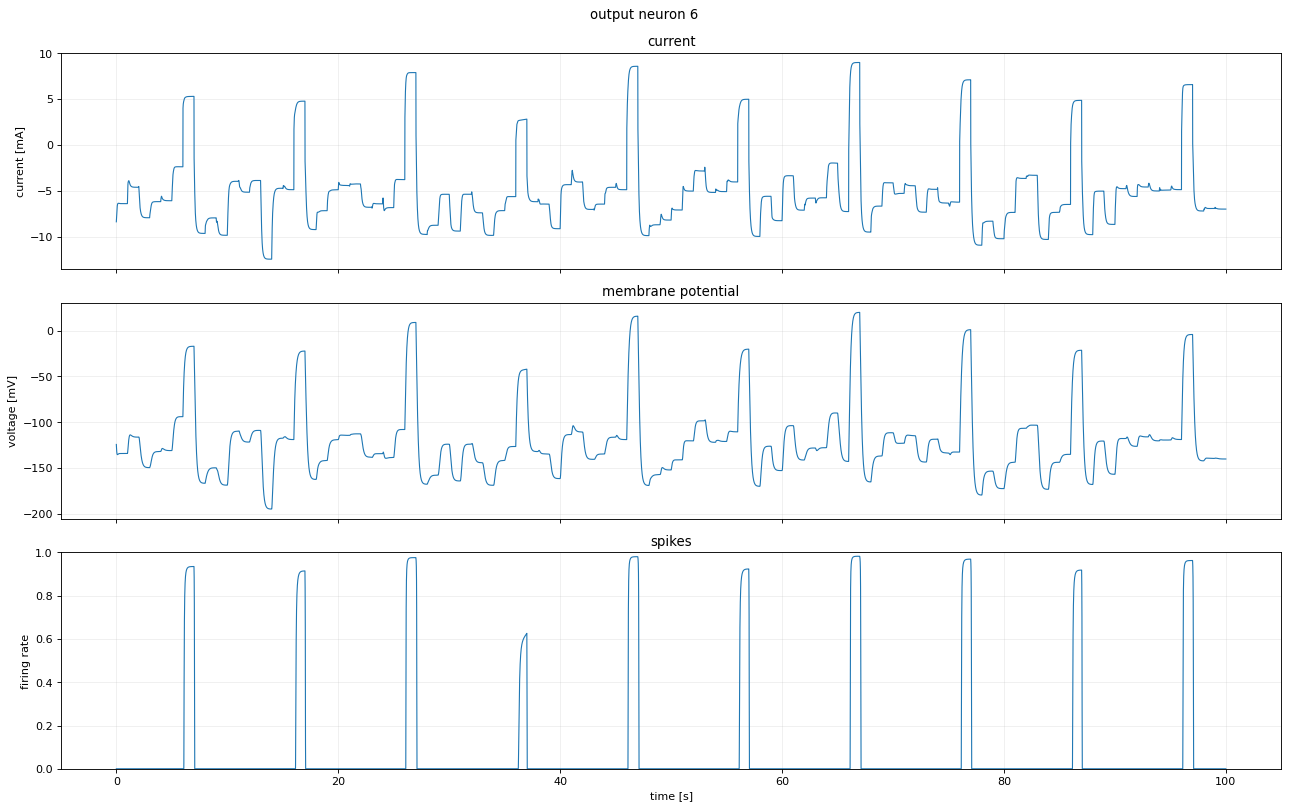

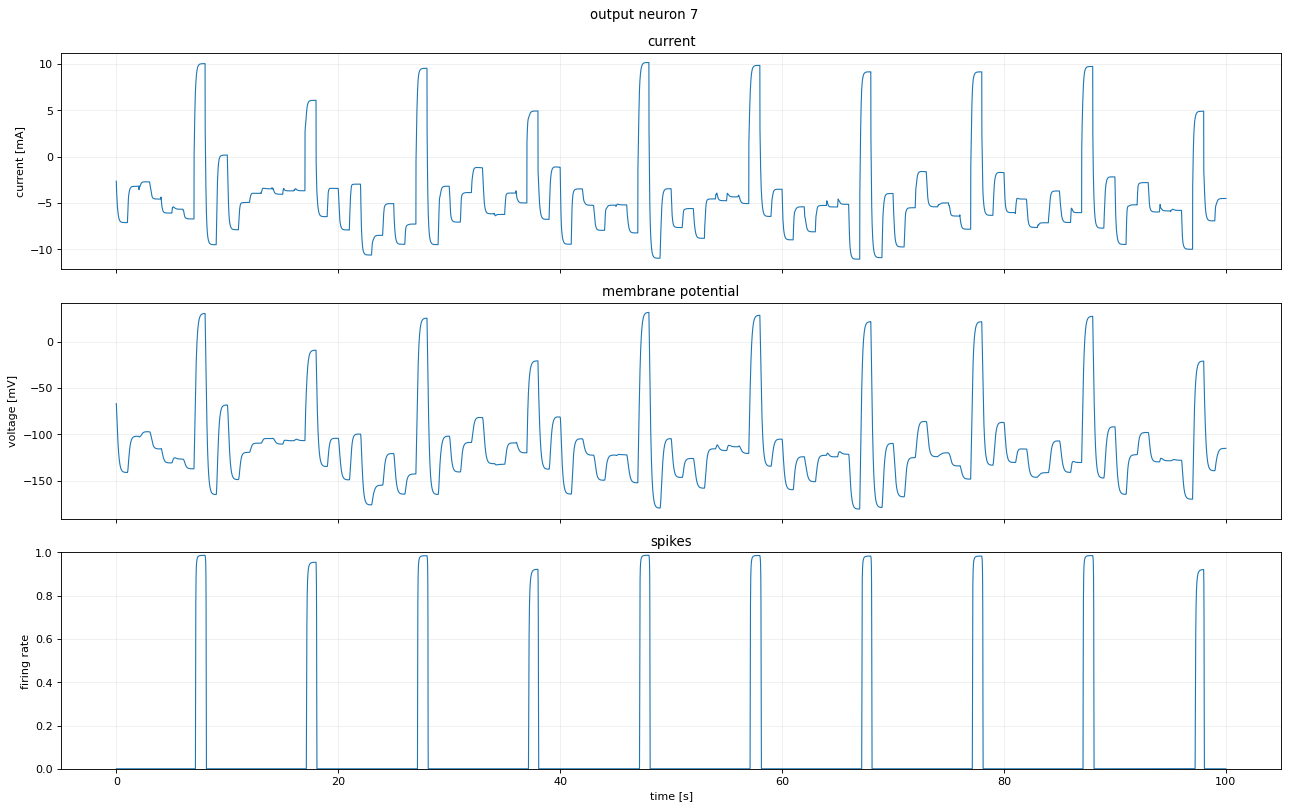

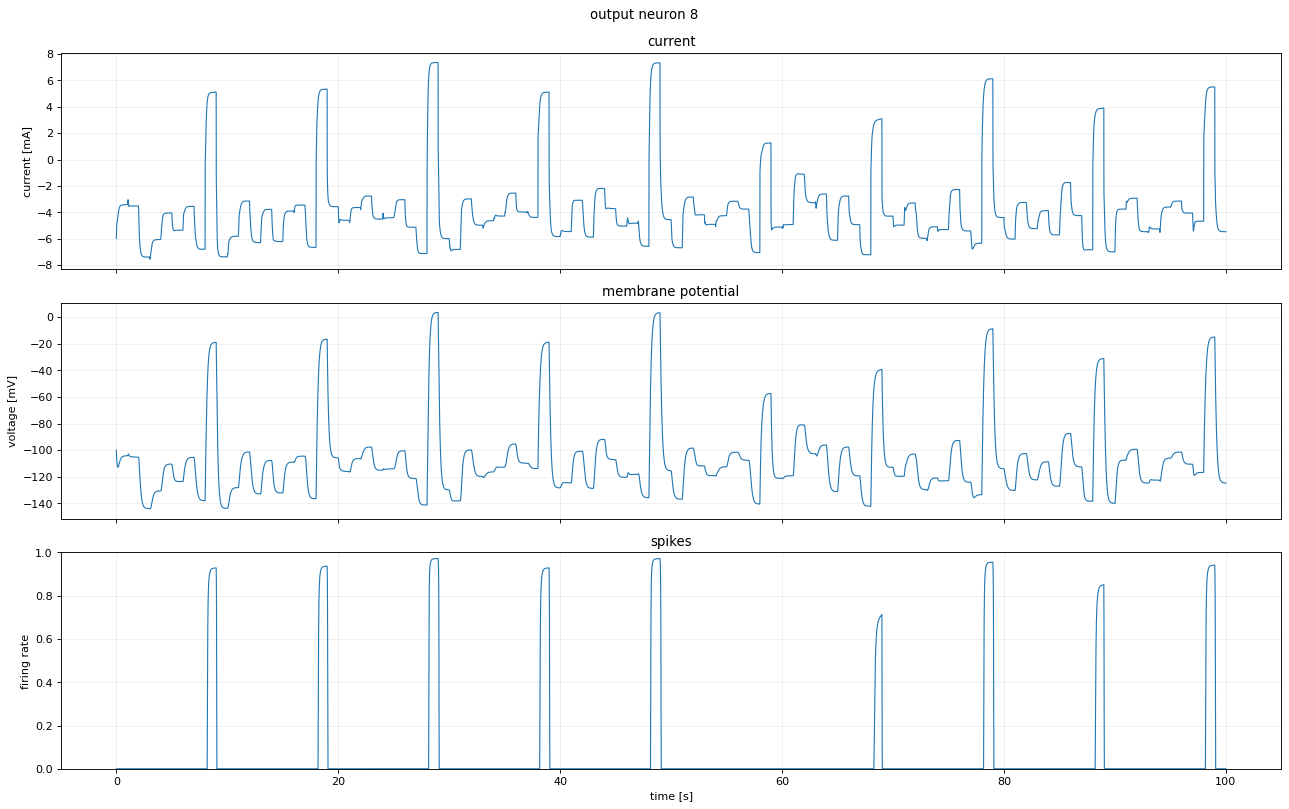

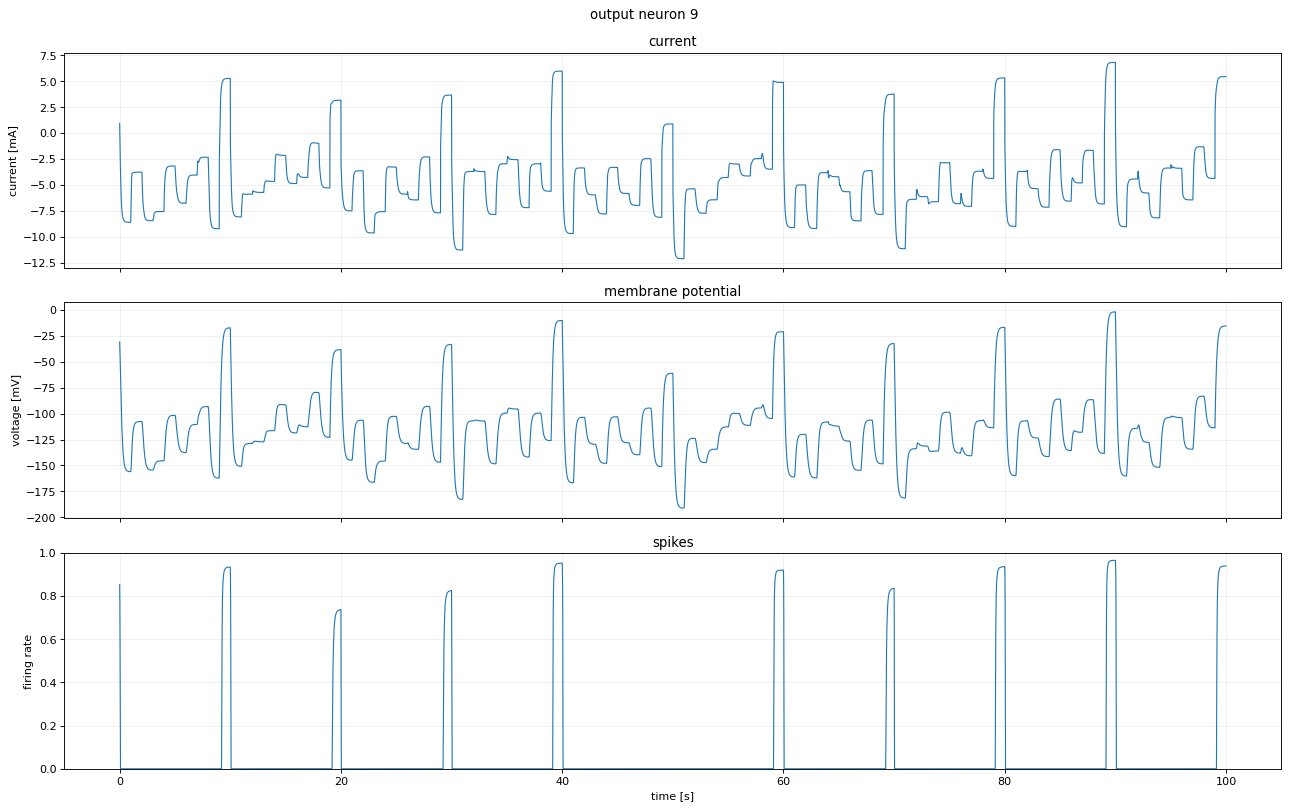

In [49]:
for i in range(10):
    plot_history_choice(net.history['output'], choice=i, title=f'output neuron {i}')

# Evaluation Simulation on Test Data

In [42]:
steps = 1000

net.bundles['input'].outputs[:] = 0

for i in range(steps):
    net.step(dt)
    print(f'{(i+1)/steps*100:.2f}%', end='\r')

In [43]:
net.reset_history()
net.record_history = True
net.train = False


dt = 0.001
time = 100
time_per_digit = 1
steps = int(time / dt)
steps_per_digit = int(time_per_digit / dt)
start = 0

print(f"total time: {time} seconds")
print(f"time_per_digit: {time_per_digit} seconds")
print()
print(f"dt: {dt}")
print(f"total_steps: {steps}")
print(f"steps per digit: {steps_per_digit}")
print()
print("begin simulation...")


predictions = []
for i in range(steps):
    if i % steps_per_digit == 0:
        net.bundles['input'].outputs[:] = x_test[int(i//steps_per_digit)].reshape(-1)
    if ((i+1) % steps_per_digit == 0):
        predictions.append(np.argmax(net.bundles['output'].outputs))
    net.step(dt)
    print(f'{(i+1)/steps*100:.2f}%', end='\r')

total time: 100 seconds
time_per_digit: 1 seconds

dt: 0.001
total_steps: 100000
steps per digit: 1000

begin simulation...


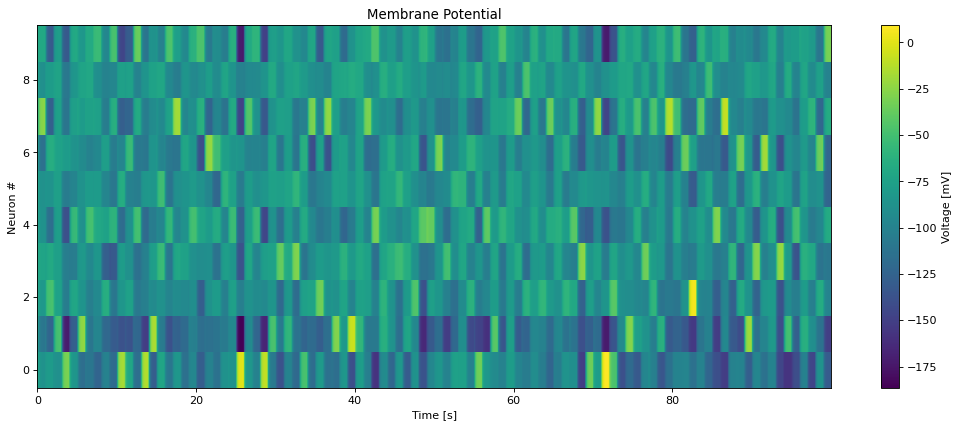

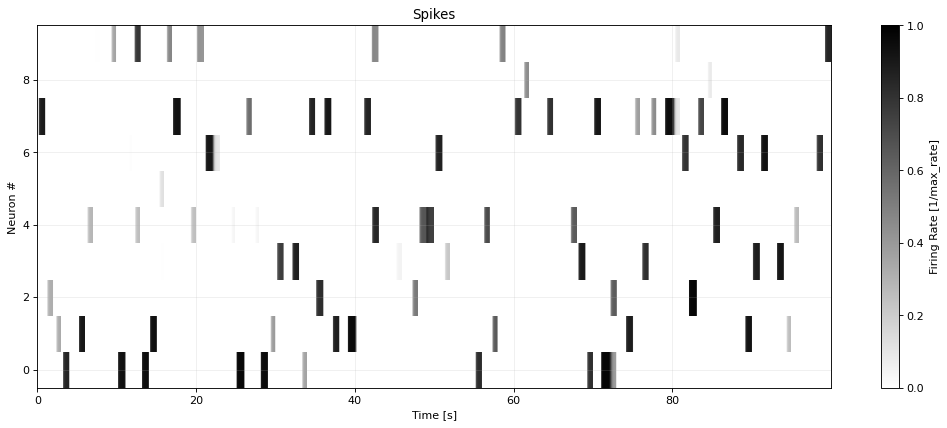

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


In [44]:
plot_voltage(net.history['output'].voltage)
plot_outputs(net.history['output'].outputs)
print(y_test[start:start+int(time//time_per_digit)])

In [36]:
# outputs = net.history['output'].outputs
# predictions = outputs.reshape(-1, int(time_per_digit/dt), 10)[:,-1]

predictions = np.array(predictions)
print(predictions.round(3))

[7 2 1 0 0 1 4 0 0 0 0 0 9 0 1 5 9 7 0 4 9 6 6 0 4 0 7 0 0 1 3 0 3 0 7 2 7
 1 0 1 0 7 4 0 0 3 0 2 4 4 6 3 0 0 0 0 4 1 9 0 7 8 0 0 7 0 0 4 3 0 7 0 0 0
 1 7 3 7 0 7 9 6 2 7 0 4 7 0 6 1 3 6 0 3 0 4 0 0 6 9]


In [37]:
scores = y_test[start:start+int(time//time_per_digit)] == predictions

print(np.mean(scores))

0.65


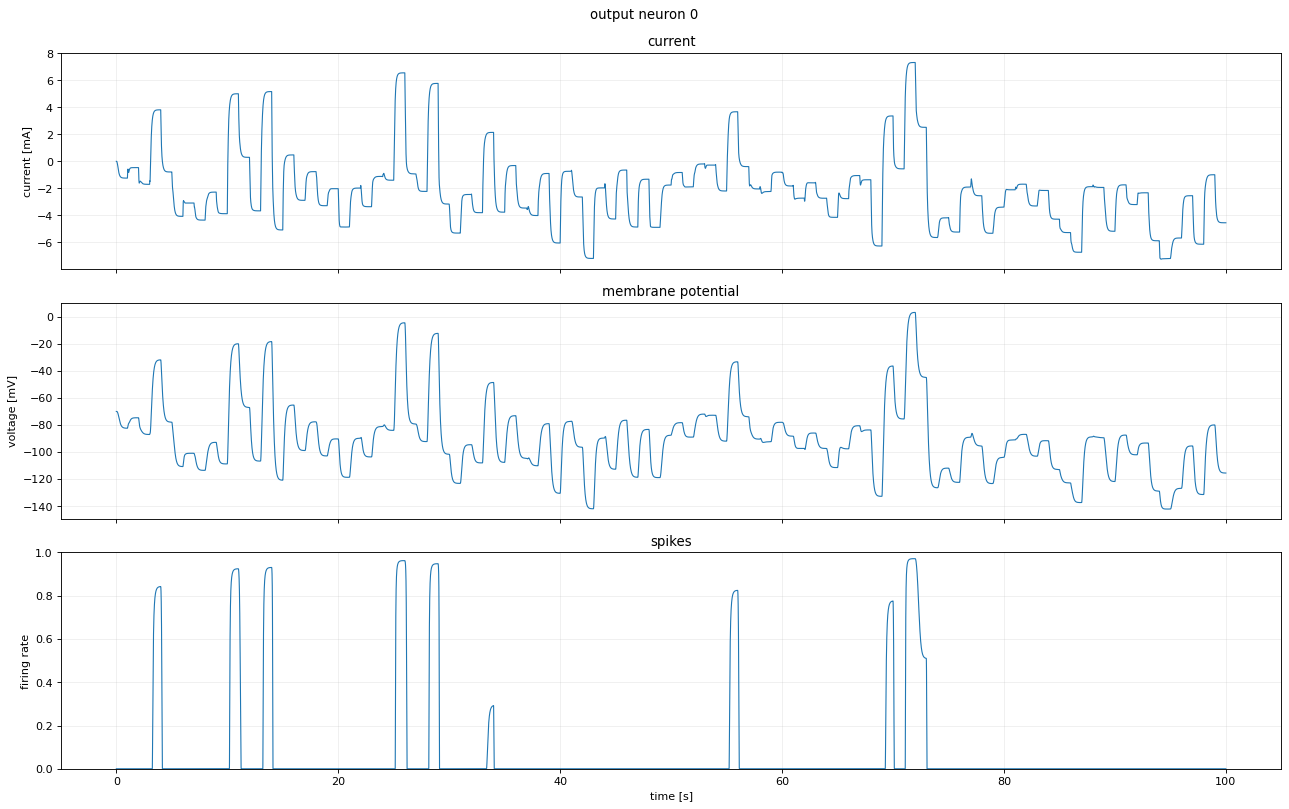

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


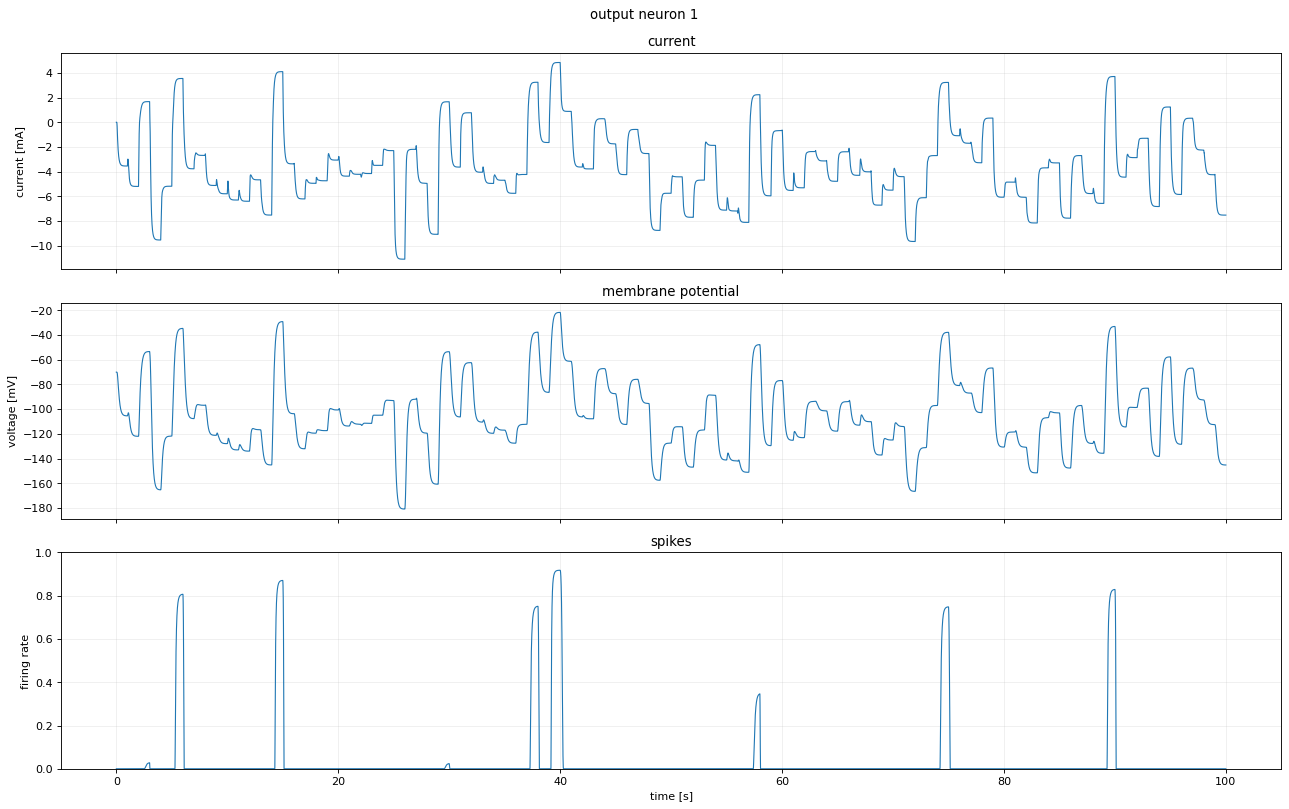

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


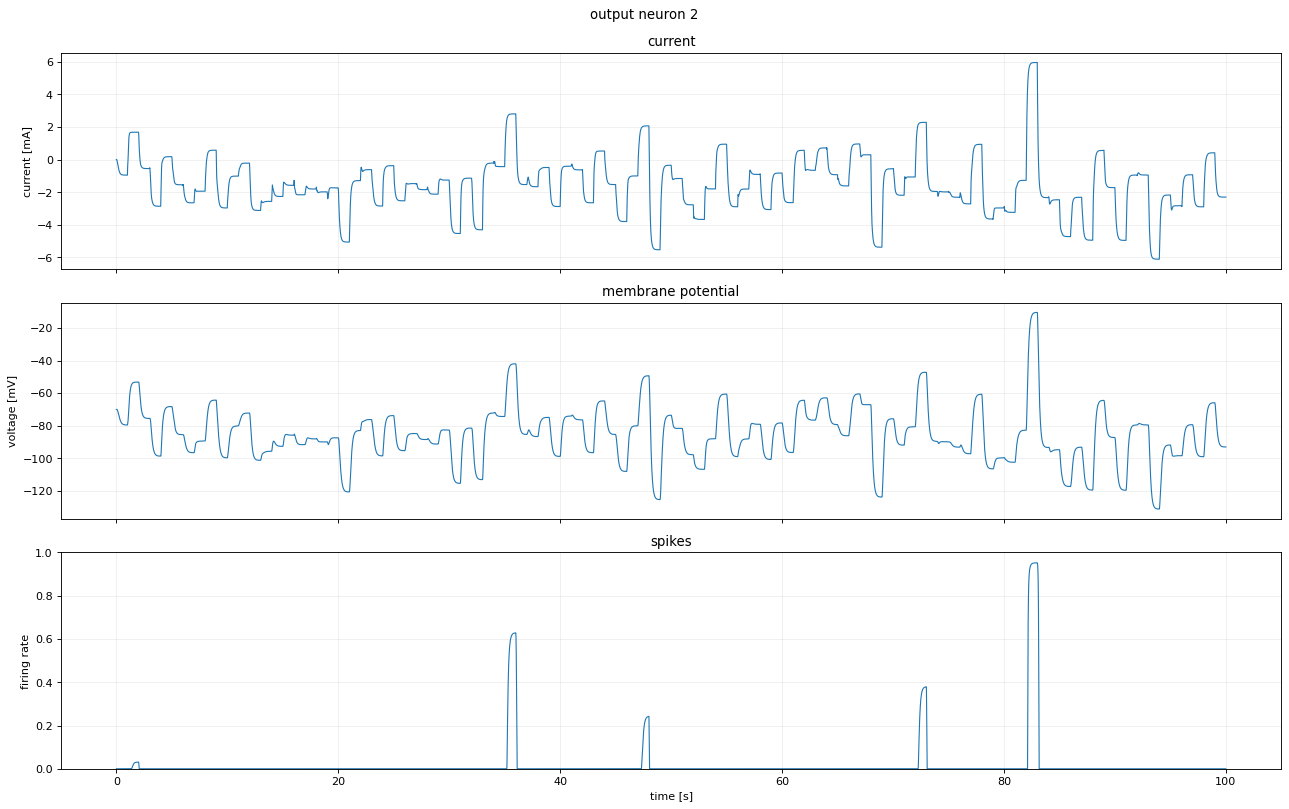

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


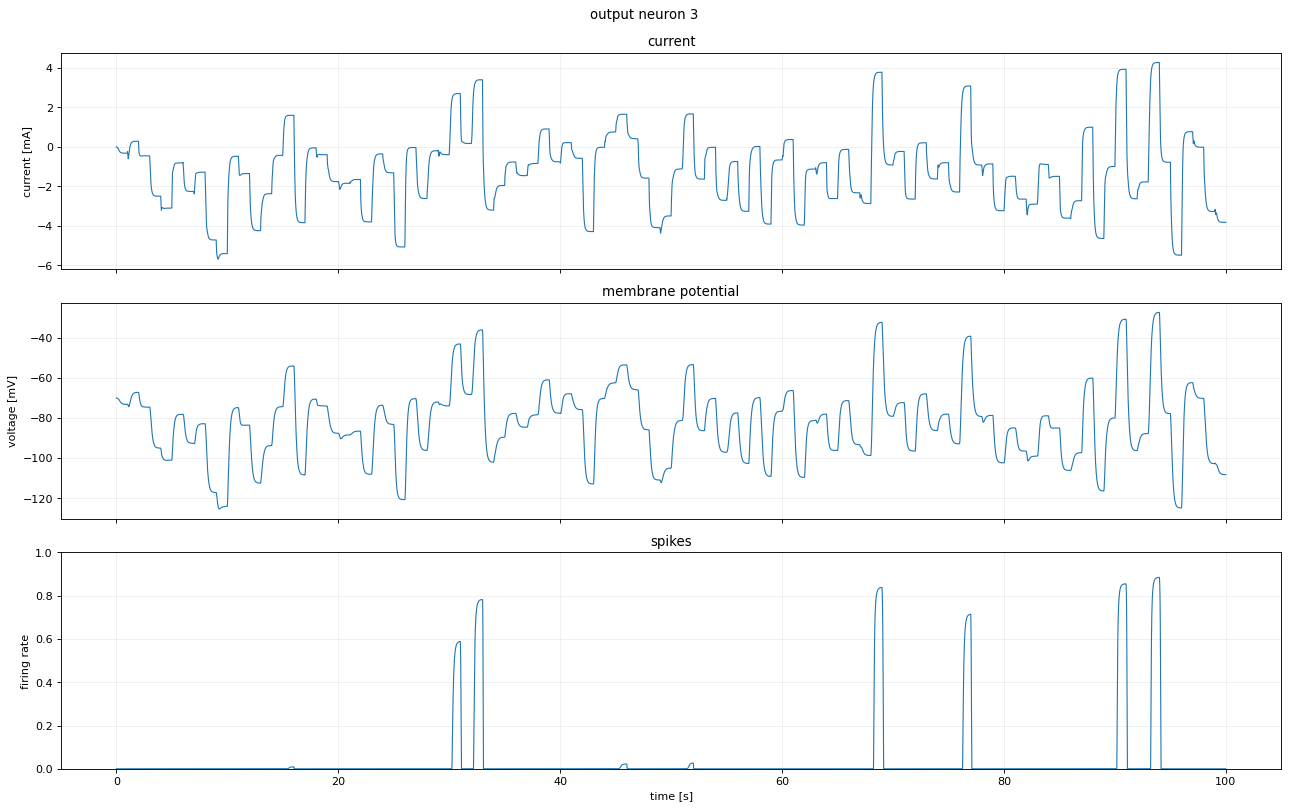

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


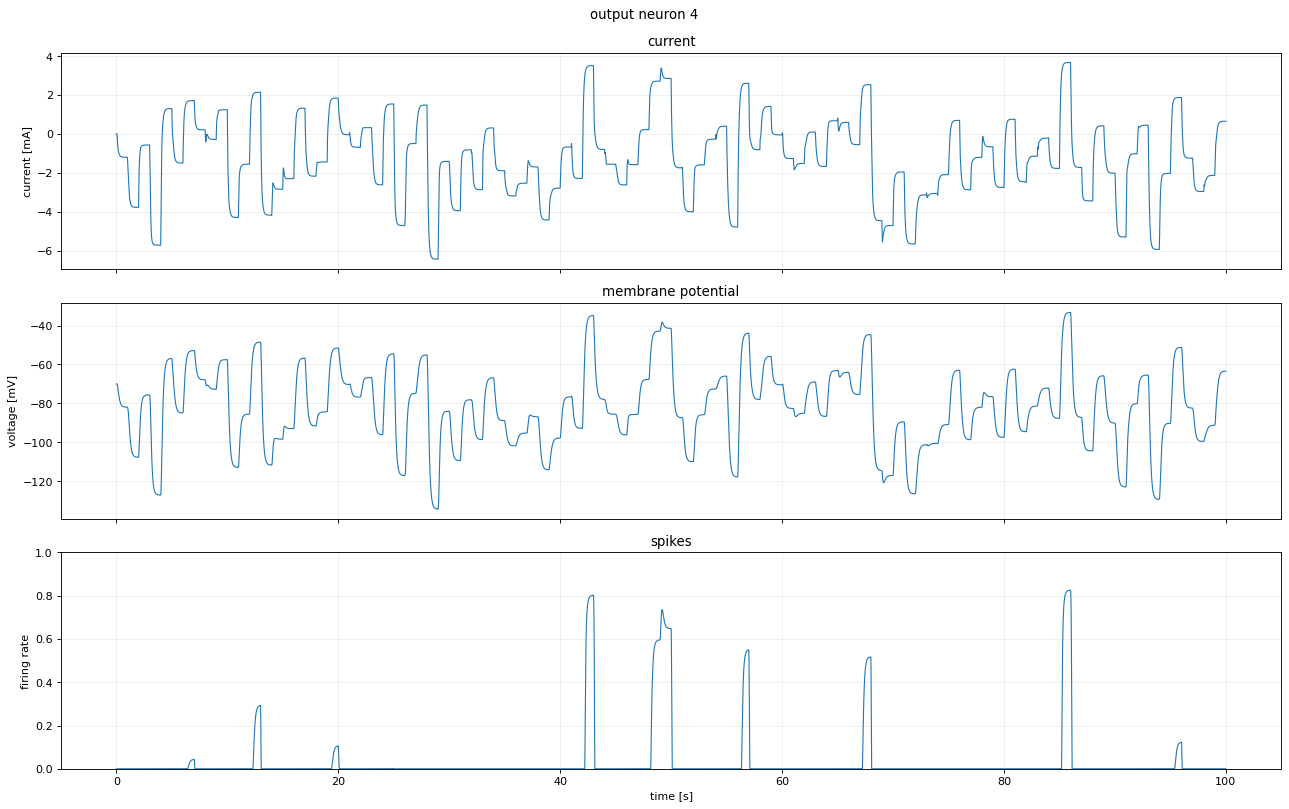

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


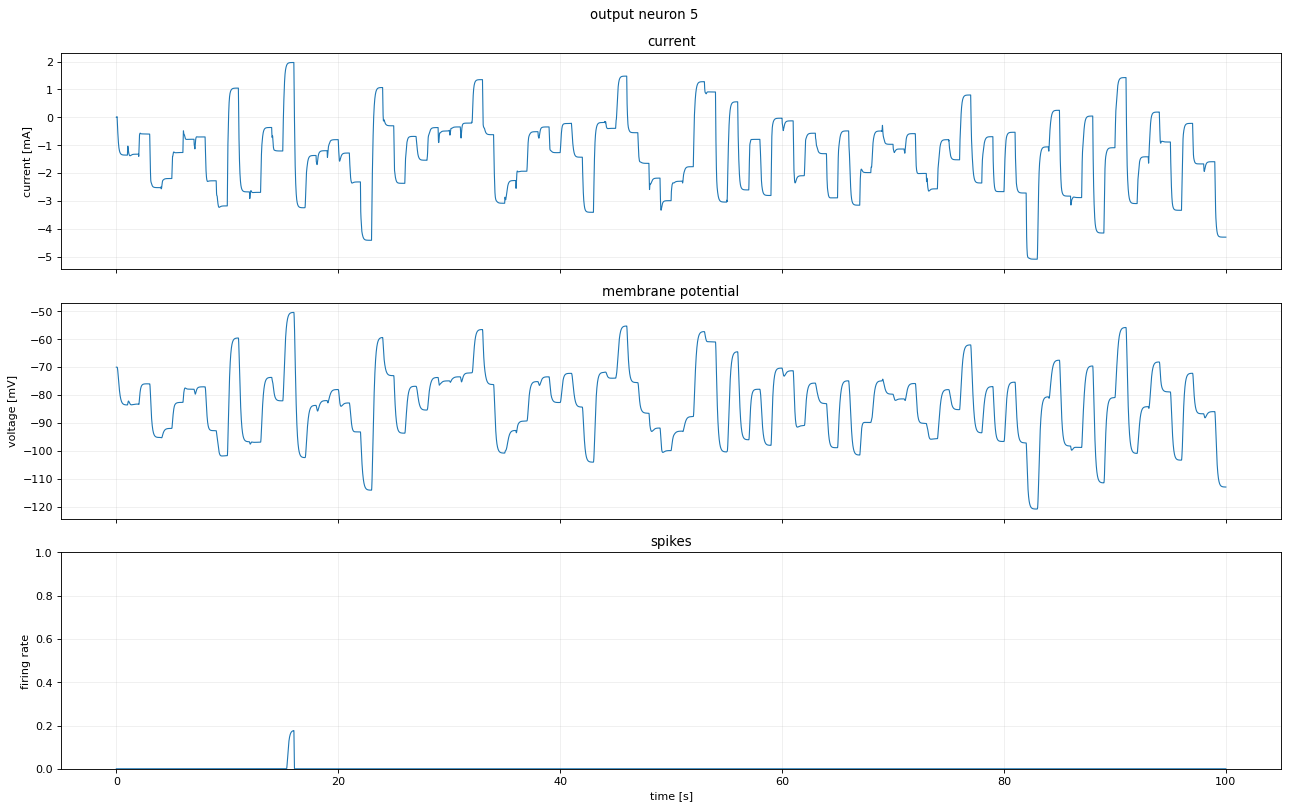

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


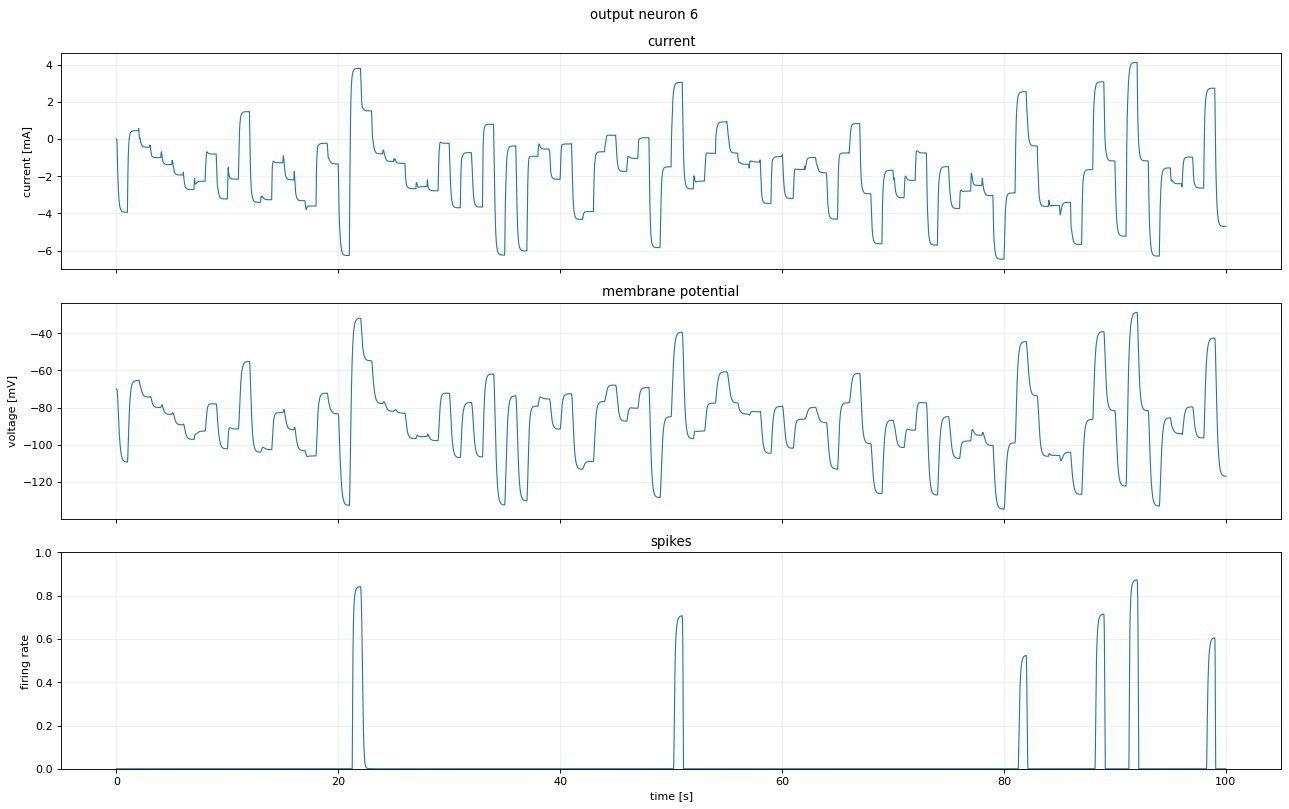

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


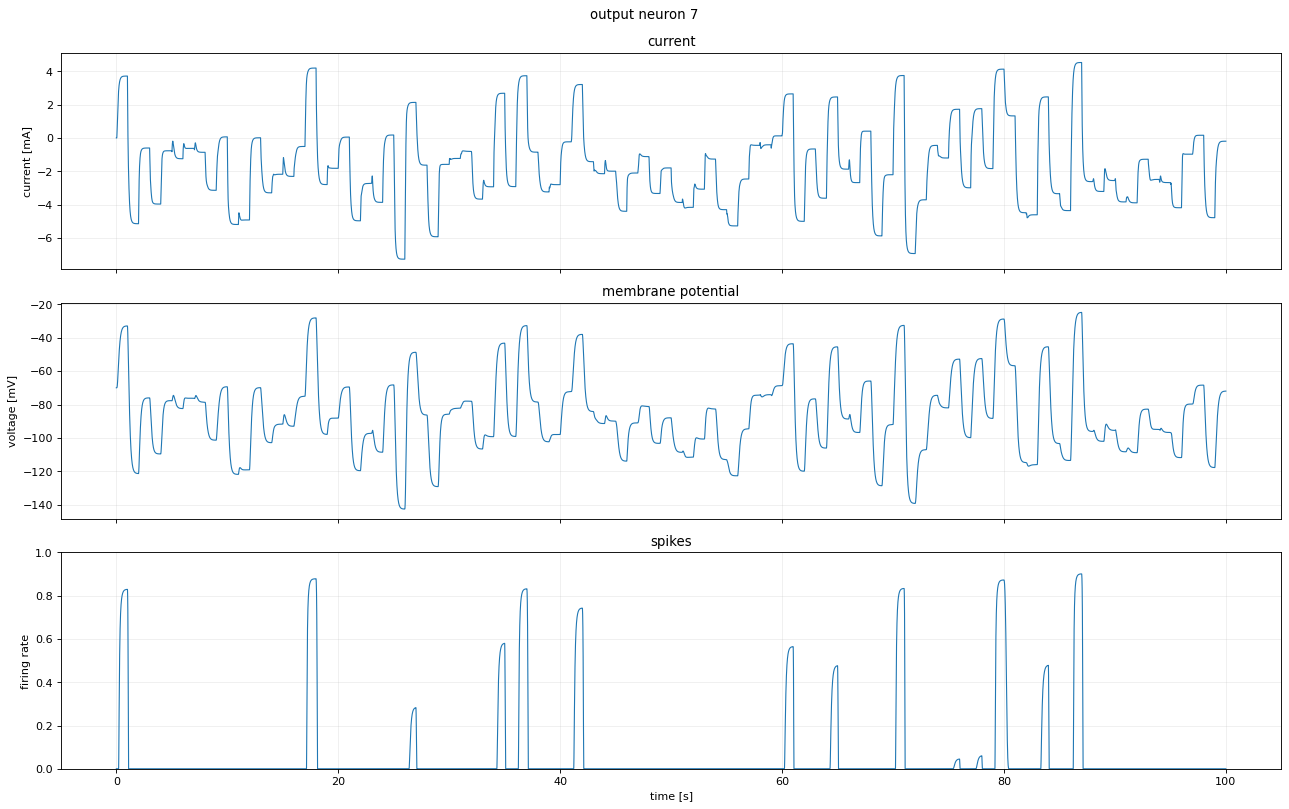

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


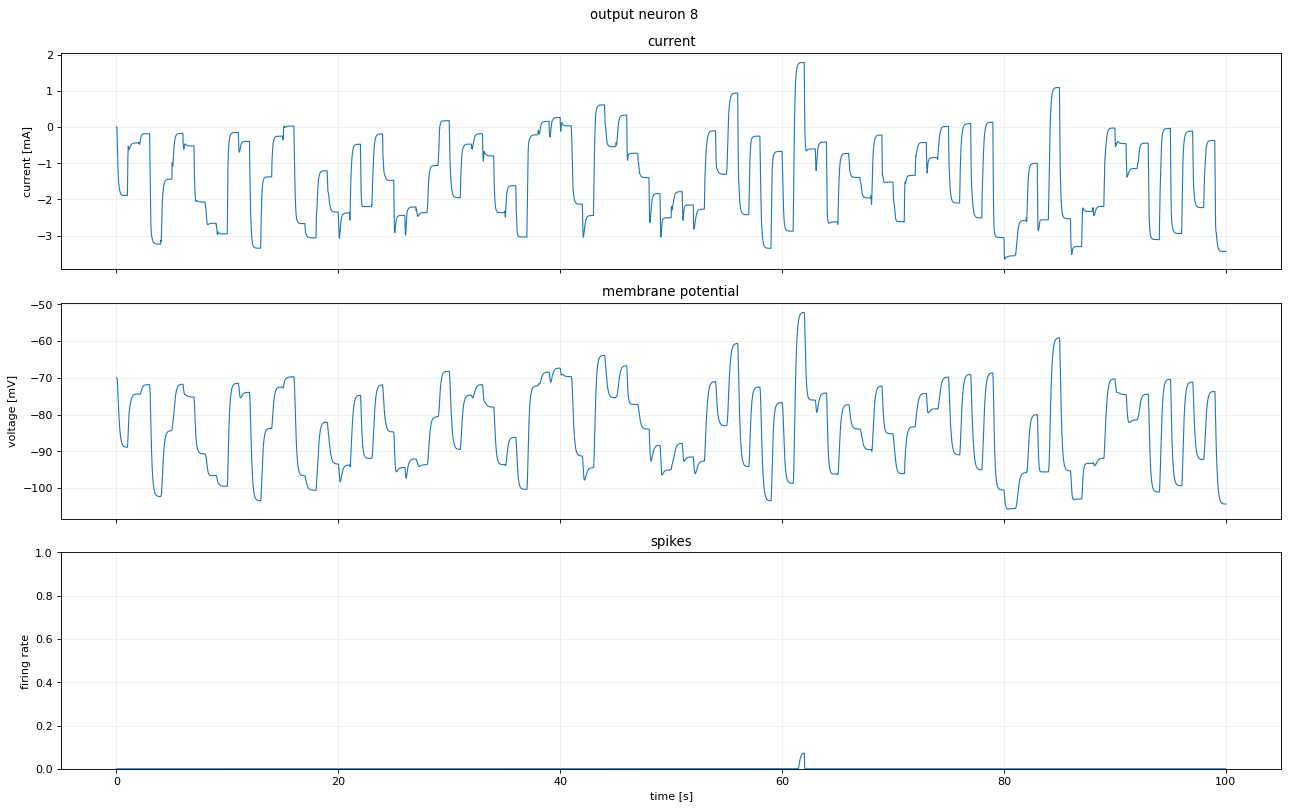

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


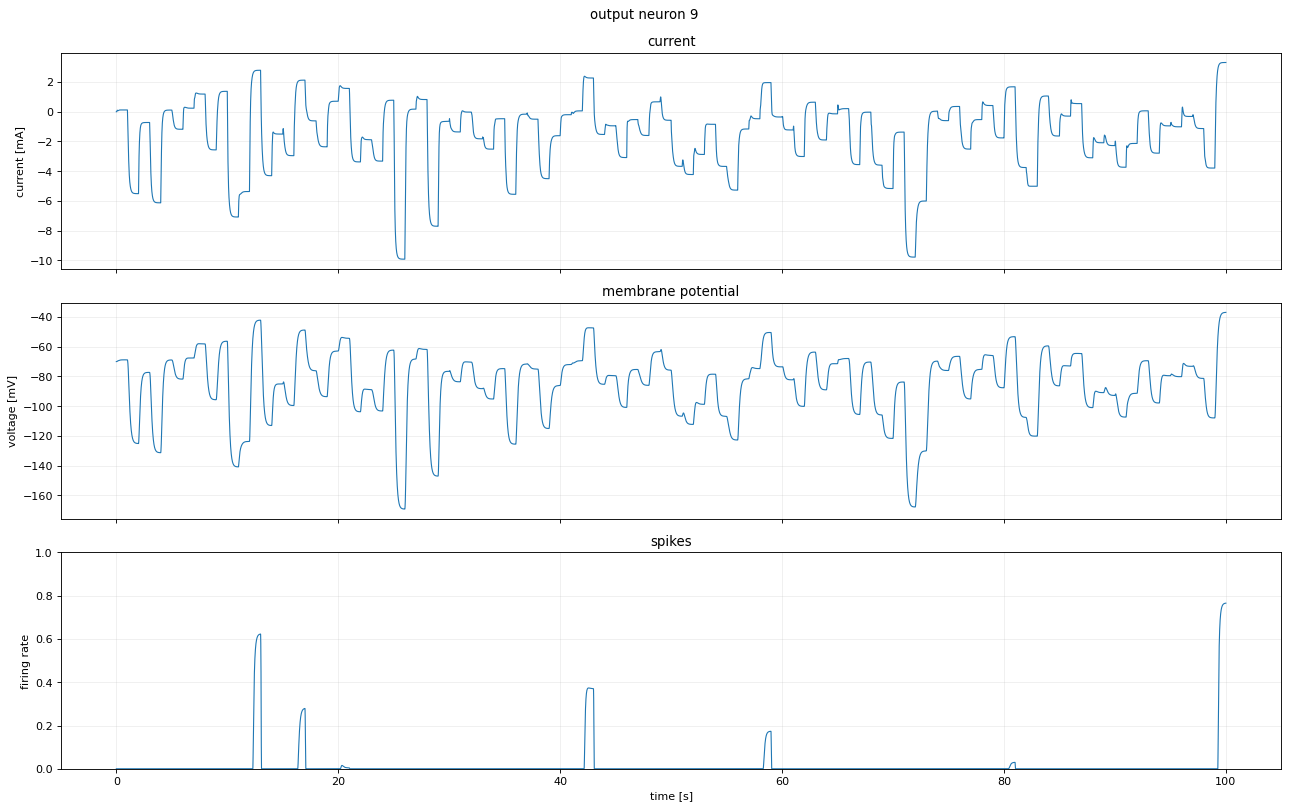

[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
 4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
 4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
 2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
 1. 7. 6. 9.]


In [38]:
for i in range(10):
    plot_history_choice(net.history['output'], choice=i, title=f'output neuron {i}')
    print(y_test[start:start+int(time//time_per_digit)])

label:       7
prediction:  7


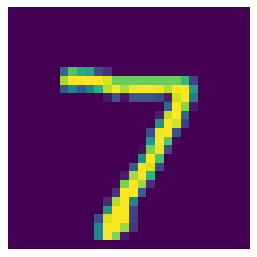

label:       2
prediction:  2


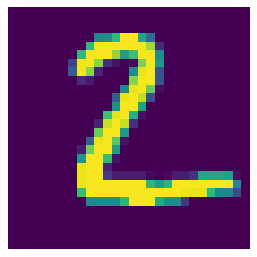

label:       1
prediction:  1


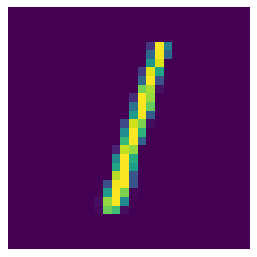

label:       0
prediction:  0


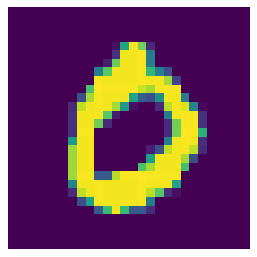

label:       4
prediction:  4


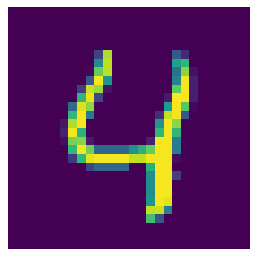

label:       1
prediction:  1


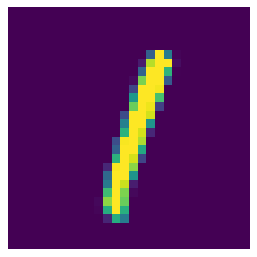

label:       4
prediction:  4


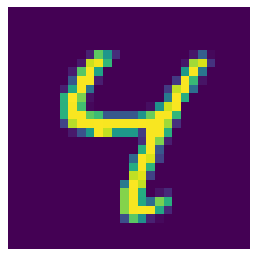

label:       9
prediction:  0


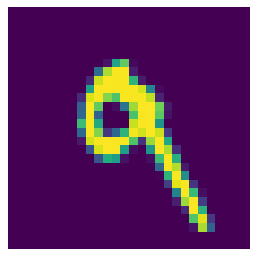

label:       5
prediction:  0


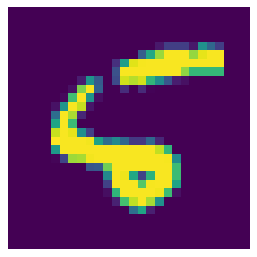

label:       9
prediction:  9


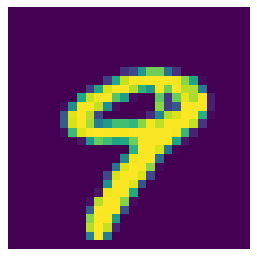

label:       0
prediction:  0


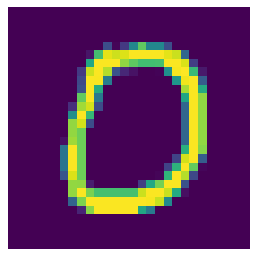

label:       6
prediction:  6


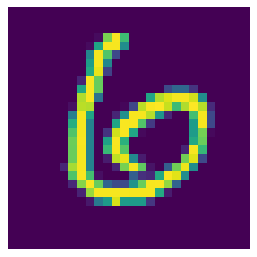

label:       9
prediction:  9


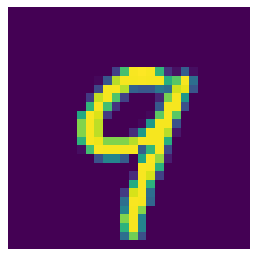

label:       0
prediction:  0


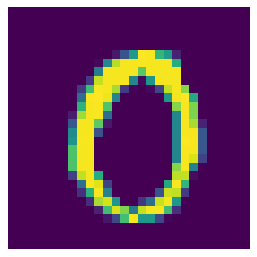

label:       1
prediction:  1


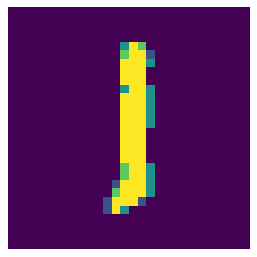

label:       5
prediction:  5


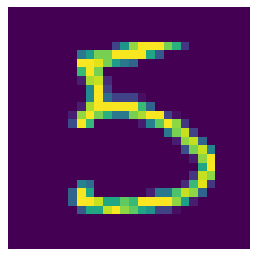

label:       9
prediction:  9


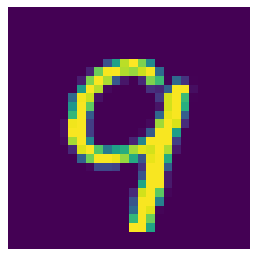

label:       7
prediction:  7


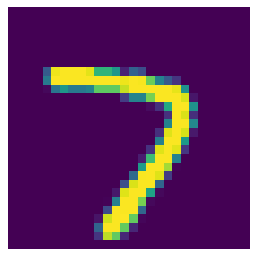

label:       3
prediction:  0


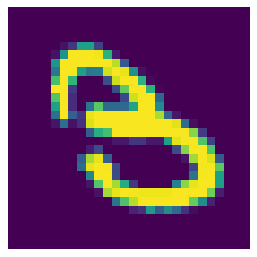

label:       4
prediction:  4


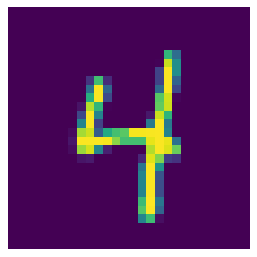

label:       9
prediction:  0


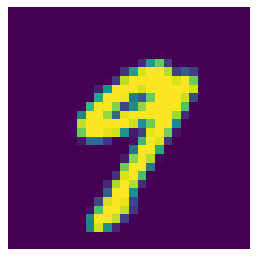

label:       6
prediction:  6


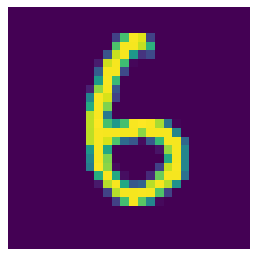

label:       6
prediction:  6


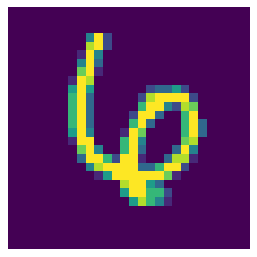

label:       5
prediction:  5


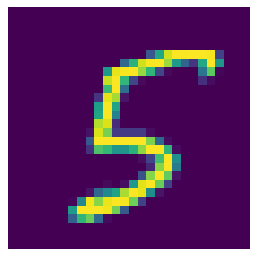

label:       4
prediction:  4


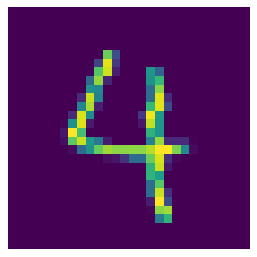

label:       0
prediction:  0


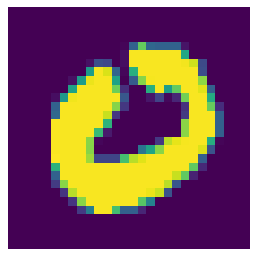

label:       7
prediction:  7


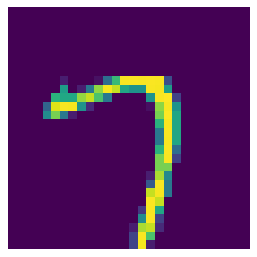

label:       4
prediction:  4


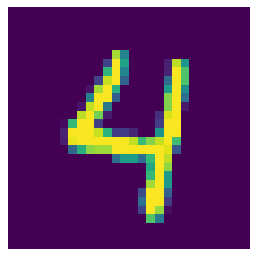

label:       0
prediction:  0


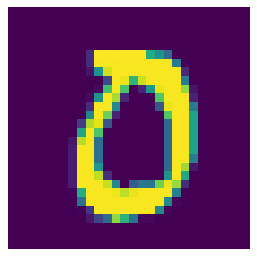

label:       1
prediction:  1


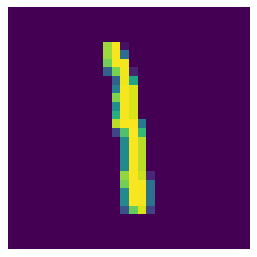

label:       3
prediction:  3


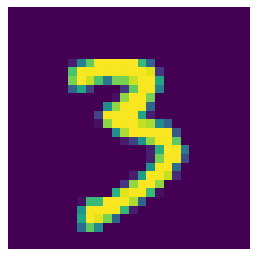

label:       1
prediction:  0


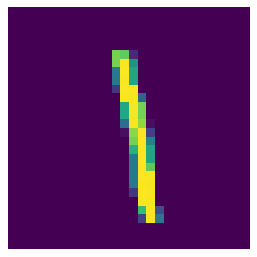

label:       3
prediction:  3


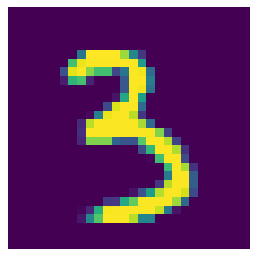

label:       4
prediction:  0


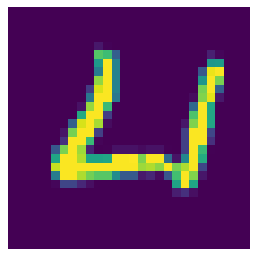

label:       7
prediction:  7


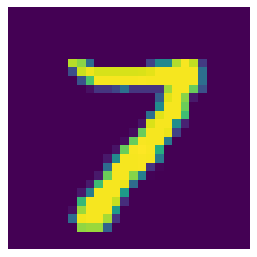

label:       2
prediction:  2


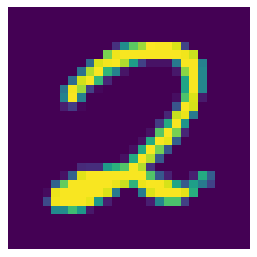

label:       7
prediction:  7


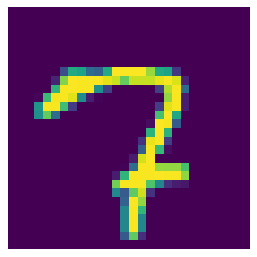

label:       1
prediction:  1


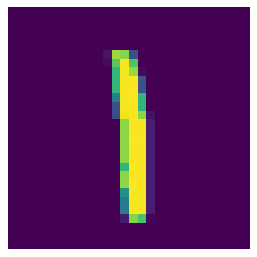

label:       2
prediction:  0


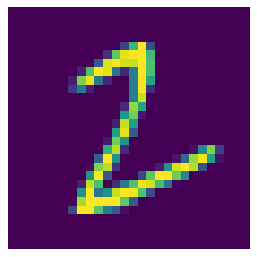

label:       1
prediction:  1


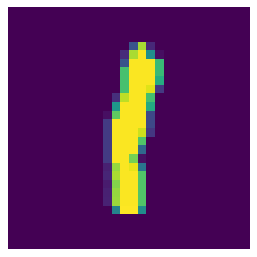

label:       1
prediction:  1


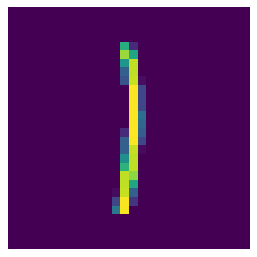

label:       7
prediction:  7


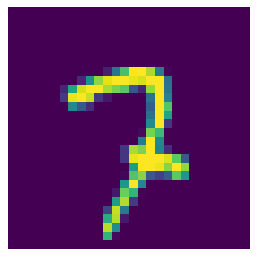

label:       4
prediction:  4


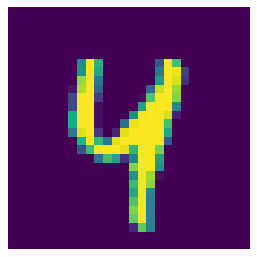

label:       2
prediction:  0


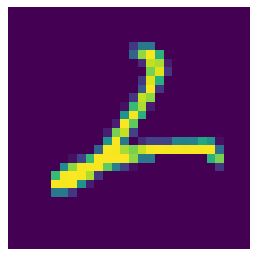

label:       3
prediction:  0


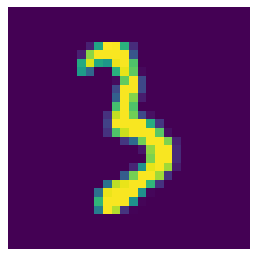

label:       5
prediction:  3


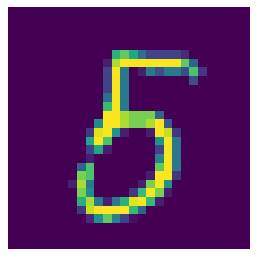

label:       1
prediction:  0


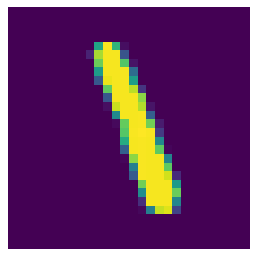

label:       2
prediction:  2


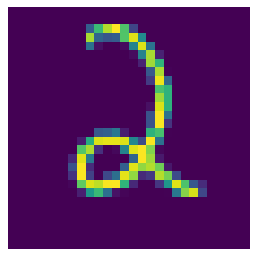

label:       4
prediction:  4


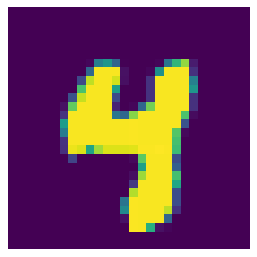

label:       4
prediction:  4


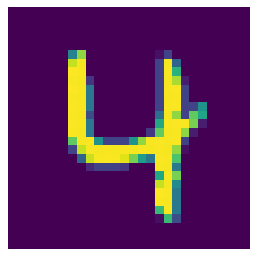

label:       6
prediction:  6


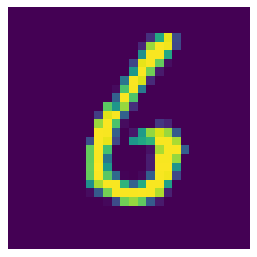

label:       3
prediction:  3


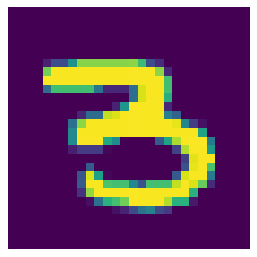

label:       5
prediction:  5


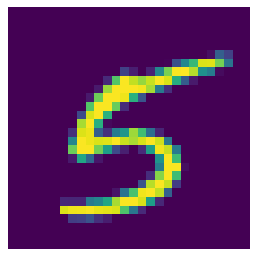

label:       5
prediction:  0


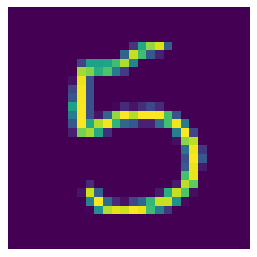

label:       6
prediction:  0


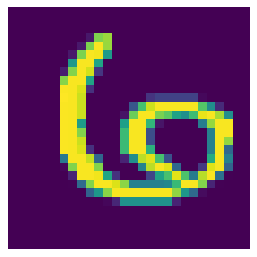

label:       0
prediction:  0


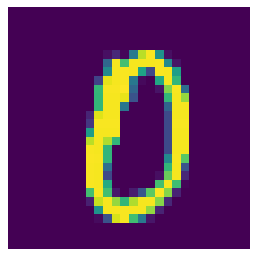

label:       4
prediction:  4


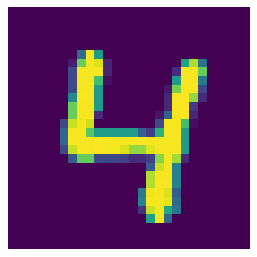

label:       1
prediction:  1


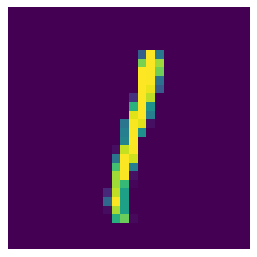

label:       9
prediction:  9


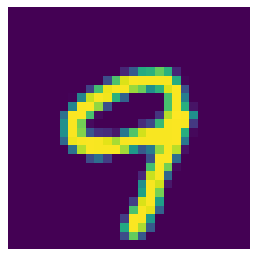

label:       5
prediction:  0


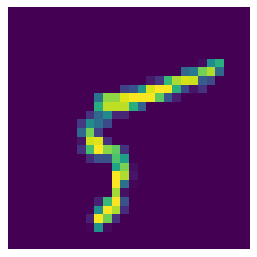

label:       7
prediction:  7


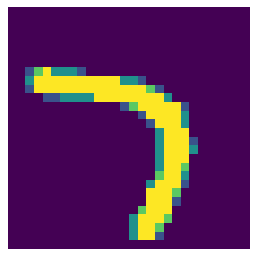

label:       8
prediction:  8


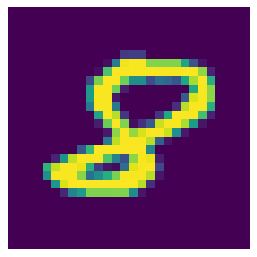

label:       9
prediction:  0


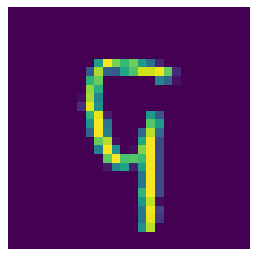

label:       3
prediction:  0


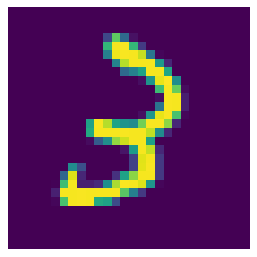

label:       7
prediction:  7


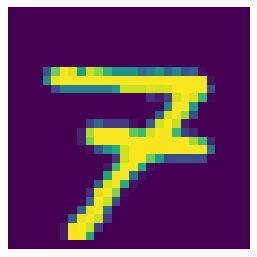

label:       4
prediction:  0


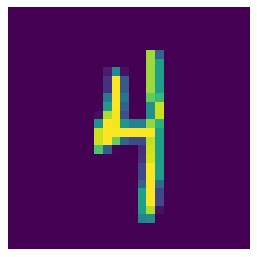

label:       6
prediction:  0


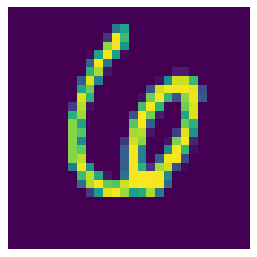

label:       4
prediction:  4


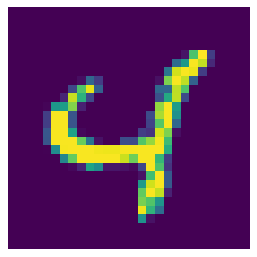

label:       3
prediction:  3


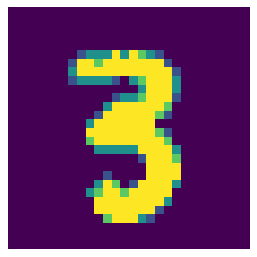

label:       0
prediction:  0


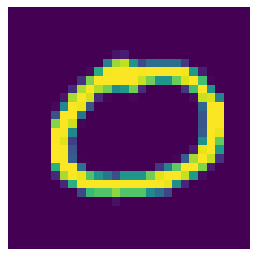

label:       7
prediction:  7


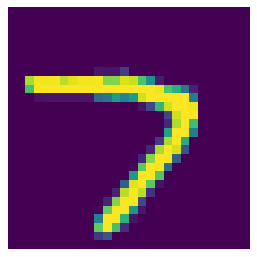

label:       0
prediction:  0


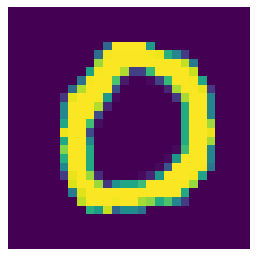

label:       2
prediction:  0


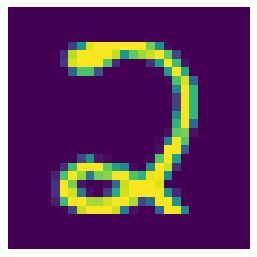

label:       9
prediction:  0


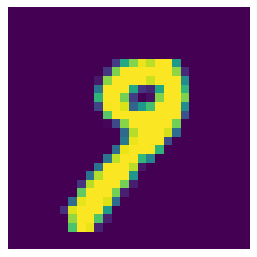

label:       1
prediction:  1


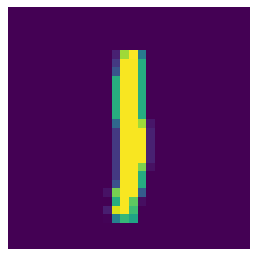

label:       7
prediction:  7


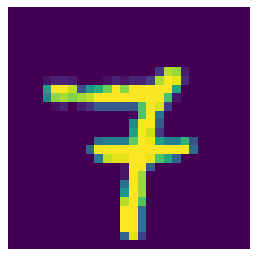

label:       3
prediction:  3


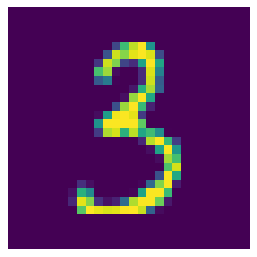

label:       2
prediction:  7


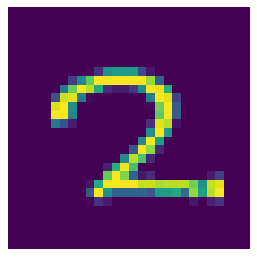

label:       9
prediction:  0


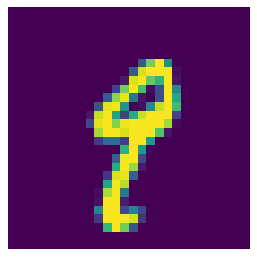

label:       7
prediction:  7


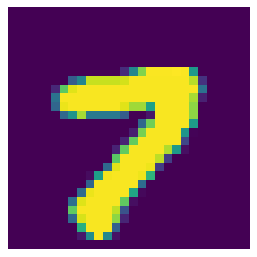

label:       7
prediction:  7


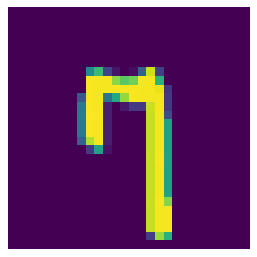

label:       6
prediction:  6


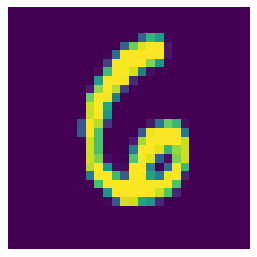

label:       2
prediction:  2


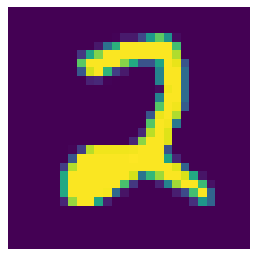

label:       7
prediction:  7


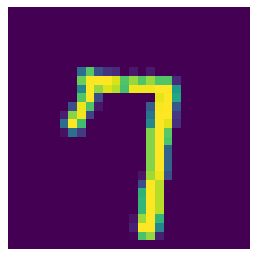

label:       8
prediction:  0


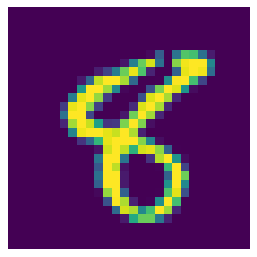

label:       4
prediction:  4


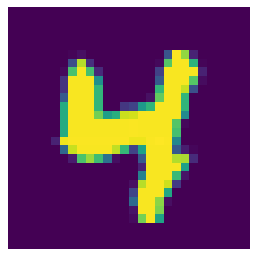

label:       7
prediction:  7


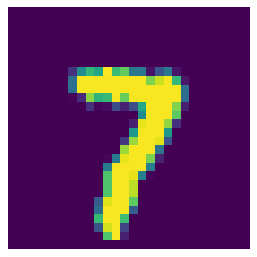

label:       3
prediction:  0


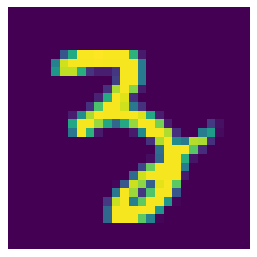

label:       6
prediction:  6


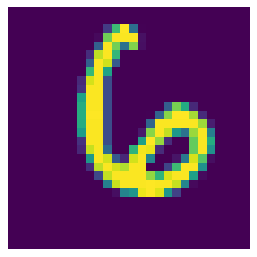

label:       1
prediction:  1


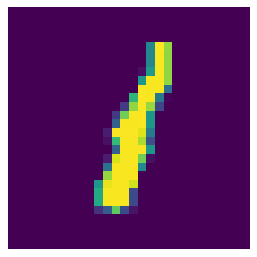

label:       3
prediction:  3


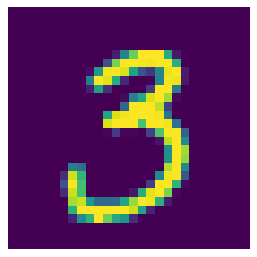

label:       6
prediction:  6


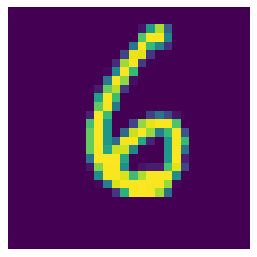

label:       9
prediction:  0


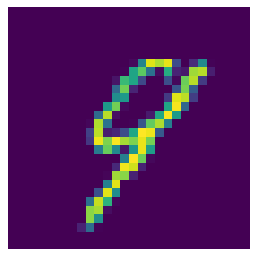

label:       3
prediction:  3


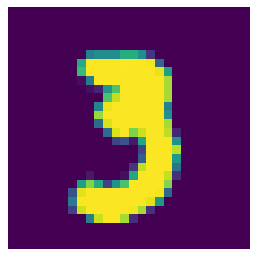

label:       1
prediction:  0


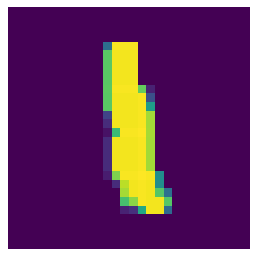

label:       4
prediction:  4


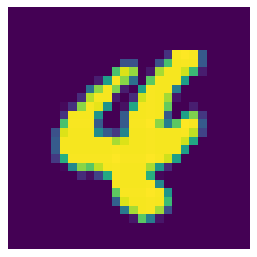

label:       1
prediction:  0


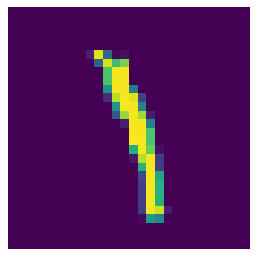

label:       7
prediction:  0


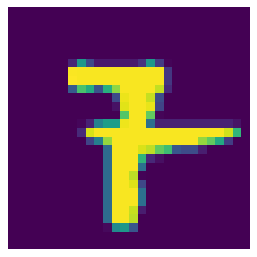

label:       6
prediction:  6


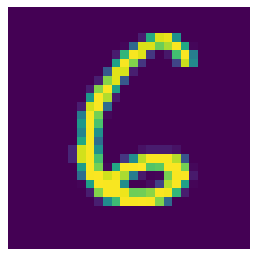

label:       9
prediction:  9


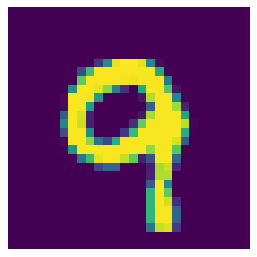

In [149]:
for i in range(start, int(start + steps / time_per_digit * dt)):
    print('label:      ', int(y_test[i]))
    print('prediction: ', predictions[i])
    show_image(x_test[i])

In [150]:
np.save('synapses_fc_hidden1000_hidden.npy', net.bundles['hidden'].synapses)
np.save('synapses_fc_hidden1000_output.npy', net.bundles['output'].synapses)